# Notes

- variance of TF compared to actual variance of baseline values
    - i.e. P2.0 figure 2
    - use to justify that effect of regulation is relatively minor
- in parity plot, label off-diagonal genes
    - case study of high/low to display that worst predictions are due to systemic issue, perhaps with accounting for regulation, leave room for improvement
    - check if those genes are/are not in iModulons
        - if they are, try iModulon activity correction
- make sure figures are reproducible if have random steps (for pub)
- restricting to length 6 -10 box may be bad for alt sigma factors; how to handle this?

# Import Packages and Construct Bitome

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymodulon.io import load_json_model
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
import shap
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from bitome.ml import *

sns.set_style('whitegrid')

shap.initjs()

In [2]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')

In [3]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

In [4]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

In [5]:
precise2 = load_json_model('../data/precise2.json.gz')

# Expression Distribution

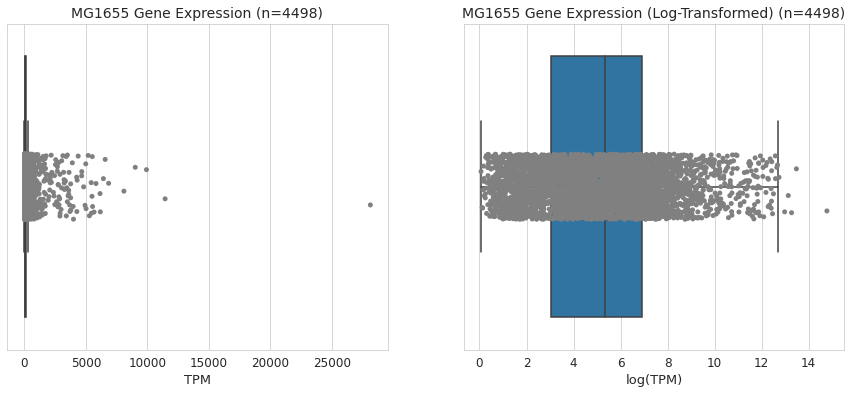

In [6]:
mg1655.expression_distribution();

# TU Expression Overview

62.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
34.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


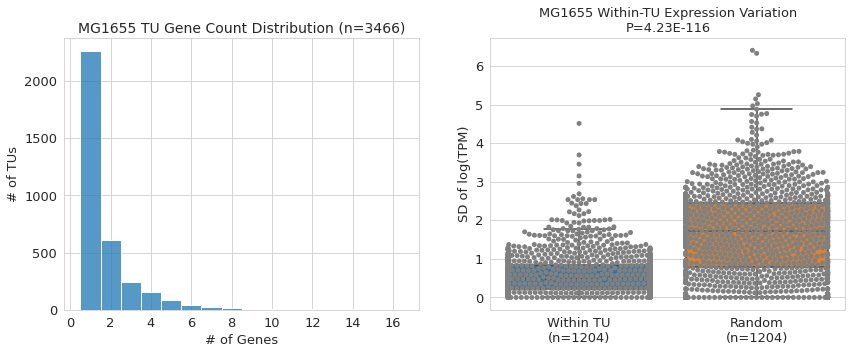

In [7]:
mg1655.within_tu_expression();

- how to handle TUs with no TSS (that just parallel the gene)
- how to handle lack of primary TU
    - BK's data should have this
    - do a comparison

# Modeling - One-Hot Features Only

## Prepare Feature Matrices

In [8]:
Xy_to_try = {}

### One-Hot Encode TSS Region

In [9]:
one_hot_tus = mg1655.one_hot_encode_tu_promoters(n_upstream=50, n_downstream=10)
one_hot_tus.head()

,-50_A,-50_C,-50_G,-50_T,-49_A,-49_C,-49_G,-49_T,-48_A,-48_C,...,8_G,8_T,9_A,9_C,9_G,9_T,10_A,10_C,10_G,10_T
ECK120008913,1,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
ECK120008914,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
ECK120008915,1,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,1,0,0
ECK120008916,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,1,0,0,0
ECK120008917,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0


### One-Hot Encode Local Regions

In [10]:
one_hot_tus_local = mg1655.one_hot_encode_tu_promoters(local_align=True, tss_radius=4, box_10_radius=10,
                                                      box_35_radius=10)
one_hot_tus_local.head()

,tss_-4_A,tss_-4_C,tss_-4_G,tss_-4_T,tss_-3_A,tss_-3_C,tss_-3_G,tss_-3_T,tss_-2_A,tss_-2_C,...,-35_8_G,-35_8_T,-35_9_A,-35_9_C,-35_9_G,-35_9_T,-35_10_A,-35_10_C,-35_10_G,-35_10_T
ECK120008913,1,0,0,0,0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,1,0
ECK120008914,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
ECK120008915,0,1,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
ECK120008916,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
ECK120008917,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


### Gene Expression-Based

- Using Average of Promoters for All TUs Containing Gene (gene_prom_avg)
- using local-aligned one-hot
- using only genes with 1 TSS (for both one-hot alignments)

In [11]:
gene_names_avg = []
gene_oh_rows_avg = []
gene_exps_avg = []
gene_exps_avg_ctrl = []
gene_exps_avg_all = []

gene_names_1tss = []
gene_oh_rows_1tss = []
gene_exps_1tss = []
gene_exps_1tss_ctrl = []
gene_exps_1tss_all = []

gene_names_local_avg = []
gene_oh_rows_local_avg = []
gene_exps_local_avg = []
gene_exps_local_avg_ctrl = []
gene_exps_local_avg_all = []

gene_names_local_1tss = []
gene_oh_rows_local_1tss = []
gene_exps_local_1tss = []
gene_exps_local_1tss_ctrl = []
gene_exps_local_1tss_all = []

for gene_row in mg1655.gene_table.itertuples():
    
    # handle the normal 1-hot
    tus_for_gene = mg1655._gene_to_tus[gene_row.Index]
    tus_in_onehot = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus.index)]
    gene_tpm = gene_row.tpm
    gene_tpm_ctrl = gene_row.tpm_ctrl
    gene_tpm_all = gene_row.tpm_all
    if tus_in_onehot and not pd.isna(gene_tpm):
        
        # handle the one-hot averaging
        tu_one_hots = one_hot_tus.loc[tus_in_onehot, :]
        tu_one_hot_avg = tu_one_hots.mean(axis=0)
        gene_names_avg.append(gene_row.Index)
        gene_oh_rows_avg.append(tu_one_hot_avg)
        gene_exps_avg.append(gene_tpm)
        gene_exps_avg_ctrl.append(gene_tpm_ctrl)
        gene_exps_avg_all.append(gene_tpm_all)
        
        # handle the single-TSS case
        if len(tus_in_onehot) == 1:
            gene_names_1tss.append(gene_row.Index)
            gene_oh_rows_1tss.append(one_hot_tus.loc[tus_in_onehot[0]])
            gene_exps_1tss.append(gene_tpm)
            gene_exps_1tss_ctrl.append(gene_tpm_ctrl)
            gene_exps_1tss_all.append(gene_tpm_all)
            
    # handle the local-aligned 1-hot
    tus_in_oh_loc = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus_local.index)]
    if tus_in_oh_loc and not pd.isna(gene_tpm):
        
        # handle the one-hot averaging
        tu_one_hots_loc = one_hot_tus_local.loc[tus_in_oh_loc, :]
        tu_one_hot_avg_loc = tu_one_hots_loc.mean(axis=0)
        gene_names_local_avg.append(gene_row.Index)
        gene_oh_rows_local_avg.append(tu_one_hot_avg_loc)
        gene_exps_local_avg.append(gene_tpm)
        gene_exps_local_avg_ctrl.append(gene_tpm_ctrl)
        gene_exps_local_avg_all.append(gene_tpm_all)
        
        # handle the single-TSS case
        if len(tus_in_oh_loc) == 1:
            gene_names_local_1tss.append(gene_row.Index)
            gene_oh_rows_local_1tss.append(one_hot_tus_local.loc[tus_in_oh_loc[0]])
            gene_exps_local_1tss.append(gene_tpm)
            gene_exps_local_1tss_ctrl.append(gene_tpm_ctrl)
            gene_exps_local_1tss_all.append(gene_tpm_all)

X_avg = pd.DataFrame(gene_oh_rows_avg, index=gene_names_avg)
Xy_to_try['prom_avg__wt'] = (X_avg, pd.Series(gene_exps_avg, index=gene_names_avg))
Xy_to_try['prom_avg__ctrl'] = (X_avg, pd.Series(gene_exps_avg_ctrl, index=gene_names_avg))
Xy_to_try['prom_avg__all'] = (X_avg, pd.Series(gene_exps_avg_all, index=gene_names_avg))

X_1tss = pd.DataFrame(gene_oh_rows_1tss, index=gene_names_1tss)
Xy_to_try['1tss__wt'] = (X_1tss, pd.Series(gene_exps_1tss, index=gene_names_1tss))
Xy_to_try['1tss__ctrl'] = (X_1tss, pd.Series(gene_exps_1tss_ctrl, index=gene_names_1tss))
Xy_to_try['1tss__all'] = (X_1tss, pd.Series(gene_exps_1tss_all, index=gene_names_1tss))

X_local_avg = pd.DataFrame(gene_oh_rows_local_avg, index=gene_names_local_avg)
Xy_to_try['local_avg__wt'] = (X_local_avg, pd.Series(gene_exps_local_avg, index=gene_names_local_avg))
Xy_to_try['local_avg__ctrl'] = (X_local_avg, pd.Series(gene_exps_local_avg_ctrl, index=gene_names_local_avg))
Xy_to_try['local_avg__all'] = (X_local_avg, pd.Series(gene_exps_local_avg_all, index=gene_names_local_avg))

X_local_1tss = pd.DataFrame(gene_oh_rows_local_1tss, index=gene_names_local_1tss)
Xy_to_try['local_1tss__wt'] = (X_local_1tss, pd.Series(gene_exps_local_1tss, index=gene_names_local_1tss))
Xy_to_try['local_1tss__ctrl'] = (X_local_1tss, pd.Series(gene_exps_local_1tss_ctrl, index=gene_names_local_1tss))
Xy_to_try['local_1tss__all'] = (X_local_1tss, pd.Series(gene_exps_local_1tss_all, index=gene_names_local_1tss))

### Finalize XY to Try

In [12]:
Xy_to_try = {
    '1tss__wt': Xy_to_try['1tss__wt'],
    'prom_avg__wt': Xy_to_try['prom_avg__wt']
}

### Set Aside Lockbox Data

In [13]:
Xy_train, Xy_lockbox = create_train_and_lockbox_sets(Xy_to_try, random_state=42)

In [48]:
Xy_train

{'1tss__wt': (       -50_A  -50_C  -50_G  -50_T  -49_A  -49_C  -49_G  -49_T  -48_A  -48_C  \
  b2502      1      0      0      0      1      0      0      0      1      0   
  b0643      0      0      0      1      0      0      1      0      0      0   
  b3013      0      0      0      1      0      0      0      1      0      1   
  b0828      1      0      0      0      0      0      0      1      0      0   
  b1251      1      0      0      0      0      1      0      0      1      0   
  ...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
  b3117      0      0      1      0      0      0      0      1      0      0   
  b3564      0      0      0      1      0      0      1      0      0      0   
  b2344      0      0      1      0      1      0      0      0      0      0   
  b4014      0      0      0      1      1      0      0      0      1      0   
  b3113      0      0      1      0      0      0      0      1      0      0   
  
         ... 

## Profile Models

In [14]:
models_to_try = {
    #'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RF': RandomForestRegressor(n_jobs=4)
    #'NN': MLPRegressor()
}

In [15]:
model_profile_df

NameError: name 'model_profile_df' is not defined

SVR: 1tss__wt__X_raw__y_raw
SVR: 1tss__wt__X_raw__y_log
SVR: 1tss__wt__X_standard__y_raw
SVR: 1tss__wt__X_standard__y_log
SVR: prom_avg__wt__X_raw__y_raw
SVR: prom_avg__wt__X_raw__y_log
SVR: prom_avg__wt__X_standard__y_raw
SVR: prom_avg__wt__X_standard__y_log
RF: 1tss__wt__X_raw__y_raw
RF: 1tss__wt__X_raw__y_log
RF: 1tss__wt__X_standard__y_raw
RF: 1tss__wt__X_standard__y_log
RF: prom_avg__wt__X_raw__y_raw
RF: prom_avg__wt__X_raw__y_log
RF: prom_avg__wt__X_standard__y_raw
RF: prom_avg__wt__X_standard__y_log


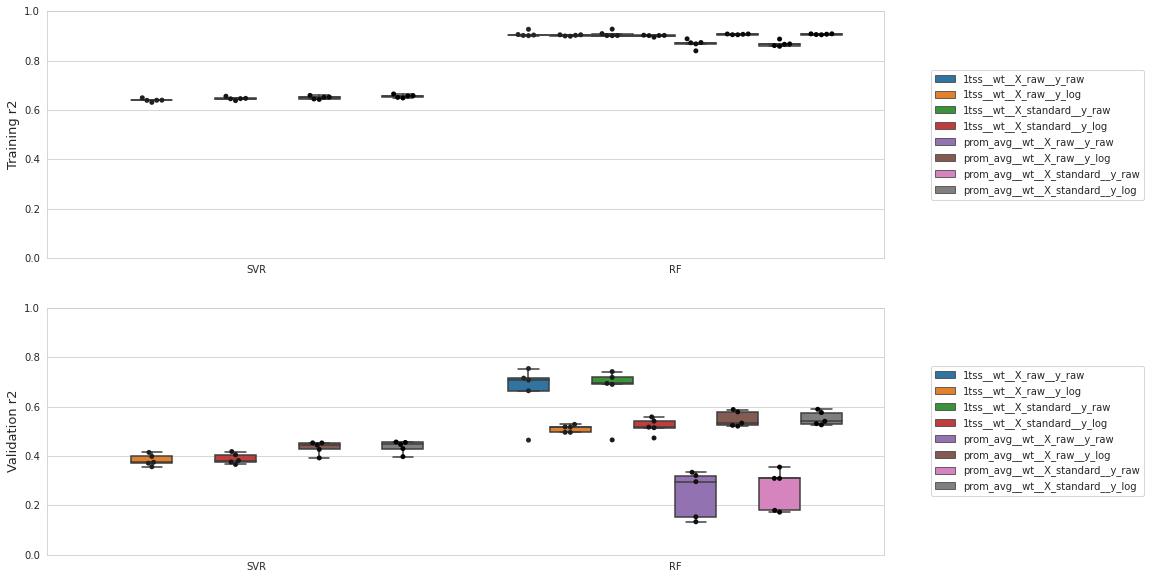

In [16]:
model_profile_df, ax_train, ax_val = profile_xy_and_models(Xy_train, models_to_try, scoring='r2', n_cv=5,
                                                           x_preprocessing=['standard'], y_preprocessing=['log'],
                                                           verbose=True)

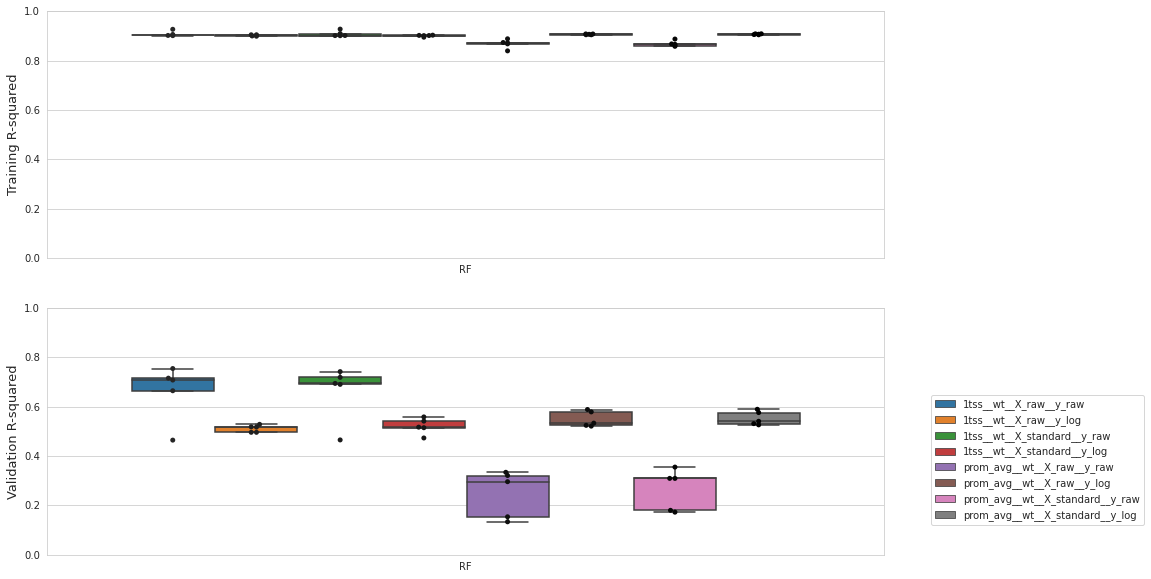

In [17]:
to_plot_df = model_profile_df[
    (model_profile_df['model'] == 'RF')
]

_, (ax_train, ax_val) = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(x='model', y='train_score', data=to_plot_df, hue='xy', dodge=True,
            fliersize=0, ax=ax_train)
sns.swarmplot(x='model', y='train_score', data=to_plot_df, hue='xy', dodge=True,
              color='black', ax=ax_train)
ax_train.get_legend().remove()
ax_train.set_xlabel('')
ax_train.set_ylabel(f'Training R-squared', fontsize=13)
ax_train.set_ylim(0, 1)

sns.boxplot(x='model', y='val_score', data=to_plot_df, hue='xy', dodge=True,
            fliersize=0, ax=ax_val)
sns.swarmplot(x='model', y='val_score', data=to_plot_df, hue='xy', dodge=True,
              color='black', ax=ax_val)
handles_val, labels_val = ax_val.get_legend_handles_labels()
ax_val.legend(handles_val[:int(len(handles_val)/2)], labels_val[:int(len(labels_val)/2)],
              loc='lower left', bbox_to_anchor=(1.05, 0.1))
ax_val.set_xlabel('')
ax_val.set_ylabel(f'Validation R-squared', fontsize=13)
ax_val.set_ylim(0, 1)

sns.set_style('whitegrid')

## Feature Importances

In [51]:
y_oh_fi_raw

b2502      93.443528
b0643     193.132010
b3013       4.289844
b0828     232.808415
b1251     309.968510
            ...     
b3117       1.143457
b3564       7.753090
b2344      88.327119
b4014    1690.209229
b3113       5.313683
Length: 1450, dtype: float64

In [18]:
x_oh_fi_raw = Xy_train['1tss__wt'][0]
x_oh_fi_std = pd.DataFrame(
    StandardScaler().fit_transform(x_oh_fi_raw),
    columns=x_oh_fi_raw.columns,
    index=x_oh_fi_raw.index
)
y_oh_fi_raw = Xy_train['1tss__wt'][1]
y_oh_fi_log = np.log2(y_oh_fi_raw.values + 1)

### Random Forest Along Promoter

<AxesSubplot:xlabel='bp from TSS', ylabel='Feature Importance'>

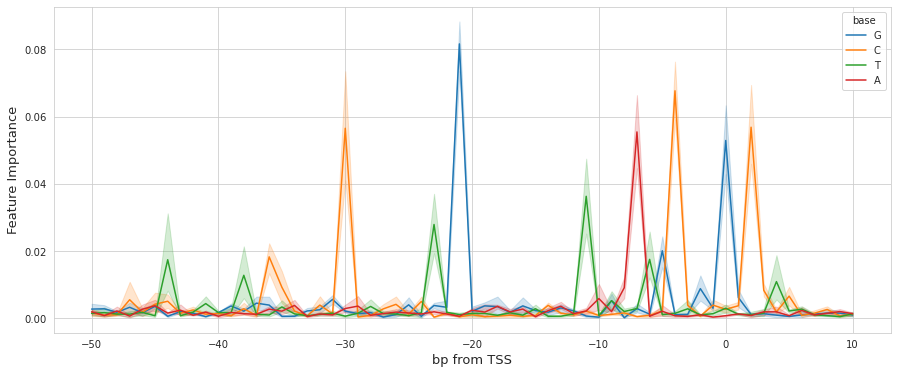

In [19]:
one_hot_feature_importance(x_oh_fi_std, y_oh_fi_raw, models_to_try['RF'], scoring='r2', n_cv=5)

### Shapley Values

In [54]:
x_oh_fi_std

,-50_A,-50_C,-50_G,-50_T,-49_A,-49_C,-49_G,-49_T,-48_A,-48_C,...,8_G,8_T,9_A,9_C,9_G,9_T,10_A,10_C,10_G,10_T
b2502,1.573918,-0.507532,-0.454228,-0.712233,1.622987,-0.480520,-0.539615,-0.672983,1.736842,-0.487033,...,-0.445362,-0.680565,-0.664343,-0.490282,-0.507532,1.545267,1.384740,-0.532152,-0.467426,-0.588500
b0643,-0.635357,-0.507532,-0.454228,1.404034,-0.616148,-0.480520,1.853173,-0.672983,-0.575758,-0.487033,...,-0.445362,-0.680565,-0.664343,2.039643,-0.507532,-0.647137,-0.722157,1.879162,-0.467426,-0.588500
b3013,-0.635357,-0.507532,-0.454228,1.404034,-0.616148,-0.480520,-0.539615,1.485922,-0.575758,2.053248,...,-0.445362,-0.680565,-0.664343,-0.490282,-0.507532,1.545267,-0.722157,-0.532152,2.139374,-0.588500
b0828,1.573918,-0.507532,-0.454228,-0.712233,-0.616148,-0.480520,-0.539615,1.485922,-0.575758,-0.487033,...,-0.445362,-0.680565,-0.664343,2.039643,-0.507532,-0.647137,-0.722157,1.879162,-0.467426,-0.588500
b1251,1.573918,-0.507532,-0.454228,-0.712233,-0.616148,2.081077,-0.539615,-0.672983,1.736842,-0.487033,...,-0.445362,-0.680565,-0.664343,-0.490282,1.970318,-0.647137,1.384740,-0.532152,-0.467426,-0.588500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b3117,-0.635357,-0.507532,2.201539,-0.712233,-0.616148,-0.480520,-0.539615,1.485922,-0.575758,-0.487033,...,2.245366,-0.680565,-0.664343,-0.490282,1.970318,-0.647137,-0.722157,-0.532152,-0.467426,1.699235
b3564,-0.635357,-0.507532,-0.454228,1.404034,-0.616148,-0.480520,1.853173,-0.672983,-0.575758,-0.487033,...,-0.445362,1.469368,-0.664343,2.039643,-0.507532,-0.647137,1.384740,-0.532152,-0.467426,-0.588500
b2344,-0.635357,-0.507532,2.201539,-0.712233,1.622987,-0.480520,-0.539615,-0.672983,-0.575758,-0.487033,...,2.245366,-0.680565,1.505246,-0.490282,-0.507532,-0.647137,-0.722157,-0.532152,-0.467426,1.699235
b4014,-0.635357,-0.507532,-0.454228,1.404034,1.622987,-0.480520,-0.539615,-0.672983,1.736842,-0.487033,...,-0.445362,-0.680565,-0.664343,-0.490282,1.970318,-0.647137,1.384740,-0.532152,-0.467426,-0.588500


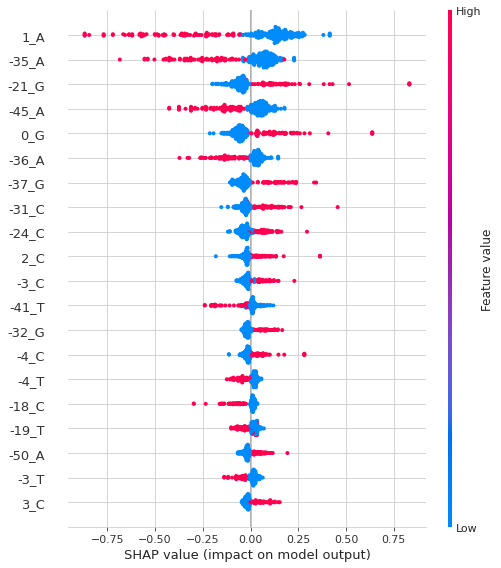

In [20]:
feature_importance(
    x_oh_fi_std,
    y_oh_fi_log,
    models_to_try['RF']
)

## Predicted vs Actual

Text(0.5, 0.05, 'R-square: 0.38\nPearson R: 0.66 (P=4.26E-37)\nSpearman R: 0.51 (P=1.81E-20)')

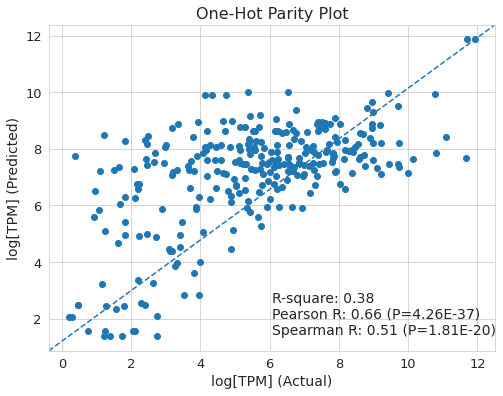

In [21]:
# split and fit the data with the given model; generate predictions
x_train, x_val, y_train, y_val = train_test_split(x_oh_fi_std, y_oh_fi_raw, test_size=0.2)
fit_model = models_to_try['RF'].fit(x_train, y_train)
y_pred = fit_model.predict(x_val)

# plot actual (x) vs predicted (y) in a parity scatterplot
y_pred_log = np.log2(y_pred + 1)
y_val_log = np.log2(y_val + 1)

r_squared = r2_score(y_val, y_pred)
pearson_r, pearson_p = pearsonr(y_val, y_pred)
spearman_r, spearman_p = spearmanr(y_val, y_pred)

_, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val_log, y_pred_log)
ax.set_xlabel('log[TPM] (Actual)', fontsize=14)
ax.set_ylabel('log[TPM] (Predicted)', fontsize=14)
ax.plot([0, 1], [0, 1], linestyle='--', transform=ax.transAxes)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('One-Hot Parity Plot', fontsize=16)
text = f'R-square: {r_squared:.2f}\nPearson R: {pearson_r:.2f} (P={pearson_p:.2E})\nSpearman R: {spearman_r:.2f} (P={spearman_p:.2E})'
ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=14)

# Genome Organization Features

In [22]:
gene_table_copy = mg1655.gene_table.copy()
# for genome bins: https://www.sciencedirect.com/science/article/pii/S0092867417315076 Figure S2
go_table = mg1655.genome_organization_table(n_genome_bins=32, tm_range=(-13, -7), tm_use_box=False).dropna()
gene_table_ml = go_table.merge(gene_table_copy, left_index=True, right_index=True, how='left')
gene_table_ml = gene_table_ml.dropna(subset=['tpm'])
# we only want things with -10 and -35 box that have length 6 (for now) so we can one-hot
gene_table_ml = gene_table_ml[
    (gene_table_ml['box_10_seq'].apply(len) == 6) &
    (gene_table_ml['box_35_seq'].apply(len) == 6)
]
# we want to allow the 'reg_effect' column to be empty, have that as category
gene_table_ml['reg_effect'] = gene_table_ml['reg_effect'].fillna('none')
gene_table_ml

,genome_loc_sin,genome_loc_cos,rep_region,origin_dist,tu_len,tu_gc,tu_order,tss_dist,tss_base,utr_len,...,pseudo,name,cog,essential,y-ome,tpm,tpm_ctrl,tpm_all,reg_effect,log_tpm
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0002,0.00000,1.000000,leading,716014,4939.000000,0.532092,2.0,189.000000,A,42.000000,...,False,thrA,E,NaN,well-annotated,911.871207,1272.481486,663.451039,unknown,9.834268
b0003,0.00000,1.000000,leading,718478,4939.000000,0.532092,3.0,2653.000000,A,42.000000,...,False,thrB,E,NaN,well-annotated,771.705903,1010.478960,576.611751,unknown,9.593776
b0004,0.00000,1.000000,leading,719411,4939.000000,0.532092,4.0,3586.000000,A,42.000000,...,False,thrC,E,NaN,well-annotated,693.743865,1004.478234,530.762368,repressed,9.440337
b0014,0.00000,1.000000,leading,727840,3194.000000,0.522972,1.0,58.000000,A,58.000000,...,False,dnaK,O,NaN,well-annotated,729.254882,759.381289,952.836122,activated,9.512256
b0015,0.00000,1.000000,leading,729845,3194.000000,0.522972,2.0,2063.000000,A,58.000000,...,False,dnaJ,O,NaN,well-annotated,168.419194,190.013853,224.440656,activated,7.404454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4397,-0.19509,0.980785,leading,709546,3487.000000,0.516499,1.0,161.000000,G,161.000000,...,False,creA,T,NaN,y-ome,82.674691,76.963569,85.927920,repressed,6.386719
b4398,-0.19509,0.980785,leading,710032,3487.000000,0.516499,2.0,647.000000,G,161.000000,...,False,creB,T,NaN,well-annotated,44.366562,60.604252,41.197456,repressed,5.503557
b4399,-0.19509,0.980785,leading,710721,3487.000000,0.516499,3.0,1336.000000,G,161.000000,...,False,creC,T,NaN,well-annotated,14.818771,16.075296,13.570748,repressed,3.983566


In [23]:
go_table

,genome_loc_sin,genome_loc_cos,rep_region,origin_dist,tu_len,tu_gc,tu_order,tss_dist,tss_base,utr_len,...,box_10_tss_dist,box_10_ext_gc,box_35_seq,box_35_tss_dist,spacer_len,spacer_gc,cid,cid_bound_dist,tu_tm,tu_gatc
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0001,0.00000,1.000000,leading,715867,2551.000000,0.502242,1.0,42.000000,A,42.000000,...,5.000000,0.333333,TTGACT,32.000000,21.000000,0.285714,cid_27,49852.000000,-9.724875,False
b0002,0.00000,1.000000,leading,716014,4939.000000,0.532092,2.0,189.000000,A,42.000000,...,5.000000,0.333333,TTGACT,32.000000,21.000000,0.285714,cid_27,49852.000000,-9.724875,False
b0003,0.00000,1.000000,leading,718478,4939.000000,0.532092,3.0,2653.000000,A,42.000000,...,5.000000,0.333333,TTGACT,32.000000,21.000000,0.285714,cid_27,49852.000000,-9.724875,False
b0004,0.00000,1.000000,leading,719411,4939.000000,0.532092,4.0,3586.000000,A,42.000000,...,5.000000,0.333333,TTGACT,32.000000,21.000000,0.285714,cid_27,49852.000000,-9.724875,False
b0014,0.00000,1.000000,leading,727840,3194.000000,0.522972,1.0,58.000000,A,58.000000,...,10.666667,0.666667,CCTATT,29.333333,12.666667,0.497863,cid_27,37895.000000,-13.493913,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4397,-0.19509,0.980785,leading,709546,3487.000000,0.516499,1.0,161.000000,G,161.000000,...,9.500000,0.666667,TTGAGA,30.500000,15.000000,0.343750,cid_27,56292.000000,-15.591829,False
b4398,-0.19509,0.980785,leading,710032,3487.000000,0.516499,2.0,647.000000,G,161.000000,...,9.500000,0.666667,TTGAGA,30.500000,15.000000,0.343750,cid_27,56292.000000,-15.591829,False
b4399,-0.19509,0.980785,leading,710721,3487.000000,0.516499,3.0,1336.000000,G,161.000000,...,9.500000,0.666667,TTGAGA,30.500000,15.000000,0.343750,cid_27,56292.000000,-15.591829,False


## Replication Region

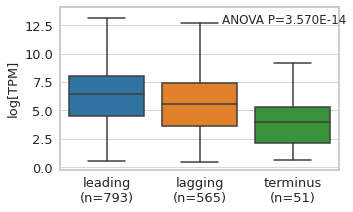

In [24]:
loc_groups = []
for loc, gloc_df in gene_table_ml.groupby('rep_region'):
    loc_groups.append(gloc_df['log_tpm'])
    
f, p = f_oneway(*loc_groups)

_, ax = plt.subplots(figsize=(5, 3))

sns.boxplot(x='rep_region', y='log_tpm',
            data=gene_table_ml, fliersize=0, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_xticklabels([f"{lab.get_text()}\n(n={gene_table_ml[gene_table_ml['rep_region'] == lab.get_text()].shape[0]})"
                       for lab in ax.get_xticklabels()])    
ax.set_ylabel('log[TPM]', fontsize=13)
ax.text(0.58, 0.9, f'ANOVA P={p:.3E}', fontsize=12, transform=ax.transAxes)
for s in ax.spines.values():
    s.set_linewidth(2)
#ax.set_title(f'MG1655 Expression by Replication Region (P = {p:.3E})', fontsize=14)
plt.savefig('expression_ml_figures/rep_region.svg')

## Distance to Origin

Text(0, 0.5, 'log[TPM]')

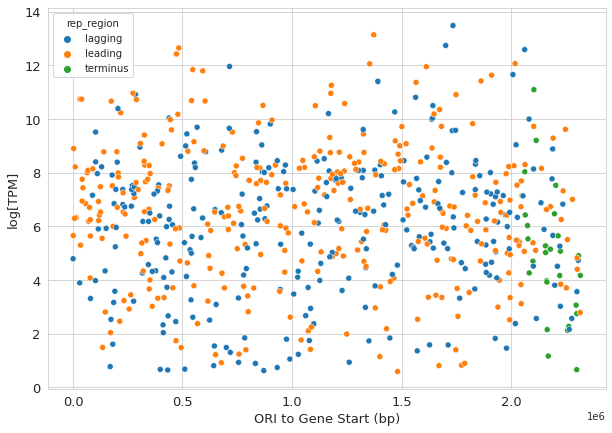

In [25]:
# only plot genes that are first in their TU to avoid multi-gene TU effects
to_plot_df = gene_table_ml[gene_table_ml['tu_order'] == 1]

_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='origin_dist', y='log_tpm', hue='rep_region', data=to_plot_df, ax=ax,
               hue_order=['lagging', 'leading', 'terminus'])
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('ORI to Gene Start (bp)', fontsize=13)
ax.set_ylabel('log[TPM]', fontsize=13)

## Genome Location

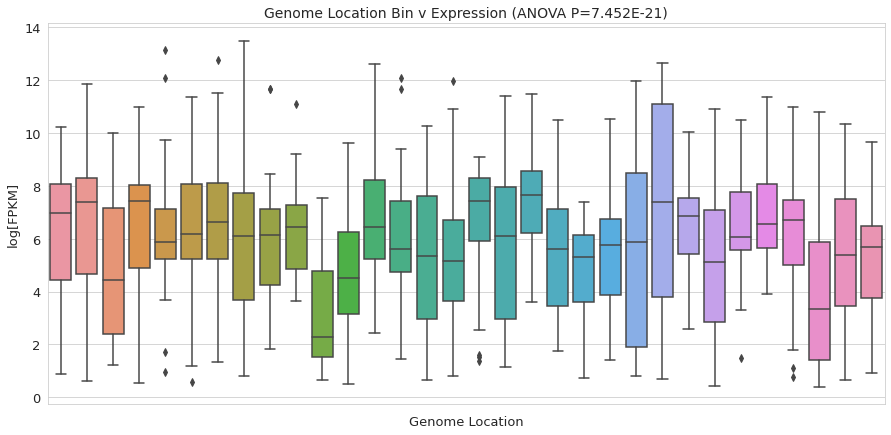

In [26]:
genome_loc_df = gene_table_ml[['genome_loc_cos', 'genome_loc_sin', 'log_tpm']].copy()
genome_loc_df['sincos'] = genome_loc_df.apply(
    lambda row: str(row.genome_loc_cos) + str(row.genome_loc_sin), axis=1
)

exp_groups = []
for sincos, gloc_df in genome_loc_df.groupby('sincos'):
    exp_groups.append(gloc_df['log_tpm'])
    
f, p = f_oneway(*exp_groups)

_, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(x='sincos', y='log_tpm', data=genome_loc_df, ax=ax, dodge=True)
ax.tick_params(axis='both', labelsize=13)
ax.tick_params(axis='x', rotation=90)
ax.set_xticklabels([])
ax.set_xlabel("Genome Location", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_title(f'Genome Location Bin v Expression (ANOVA P={p:.3E})', fontsize=14);

## CID (Experimental)

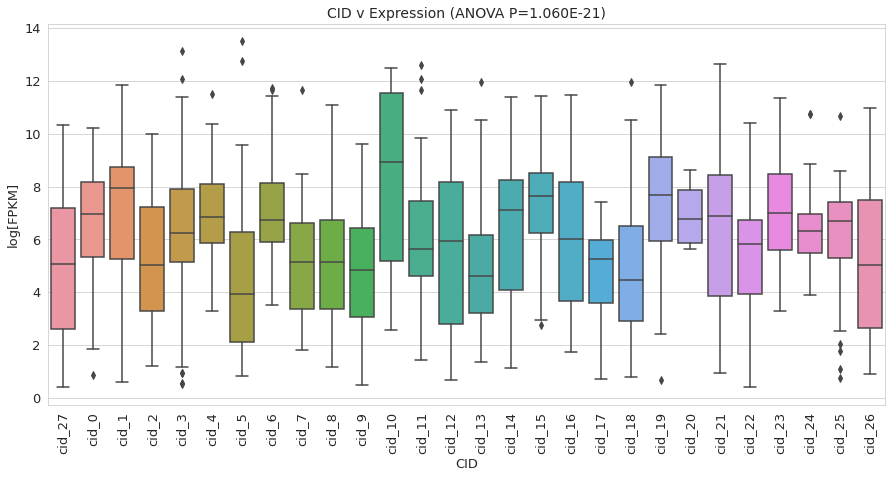

In [27]:
exp_groups = []
for cid, cid_df in gene_table_ml.groupby('cid'):
    exp_groups.append(cid_df['log_tpm'])
    
f, p = f_oneway(*exp_groups)

_, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(x='cid', y='log_tpm', data=gene_table_ml, ax=ax, dodge=True)
ax.tick_params(axis='both', labelsize=13)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel("CID", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_title(f'CID v Expression (ANOVA P={p:.3E})', fontsize=14);

## CID Boundary Distance

Text(0, 0.5, 'log[TPM]')

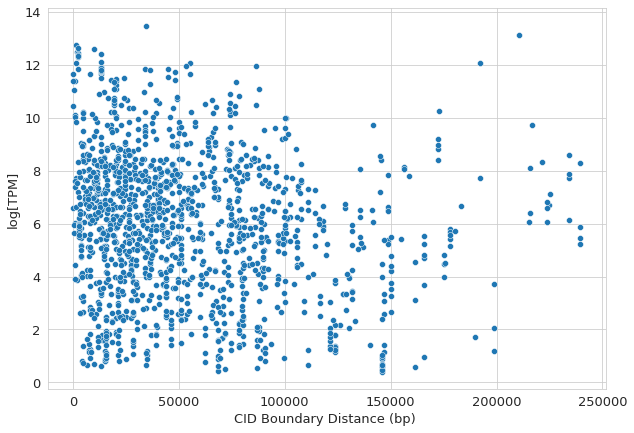

In [28]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='cid_bound_dist', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("CID Boundary Distance (bp) ", fontsize=13)
ax.set_ylabel('log[TPM]', fontsize=13)

## Melting Temperature

Text(0, 0.5, 'log[TPM]')

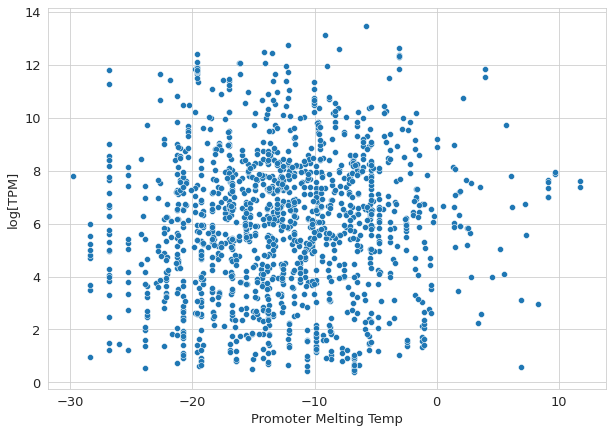

In [29]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='tu_tm', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("Promoter Melting Temp", fontsize=13)
ax.set_ylabel('log[TPM]', fontsize=13)

## Methylation Sites

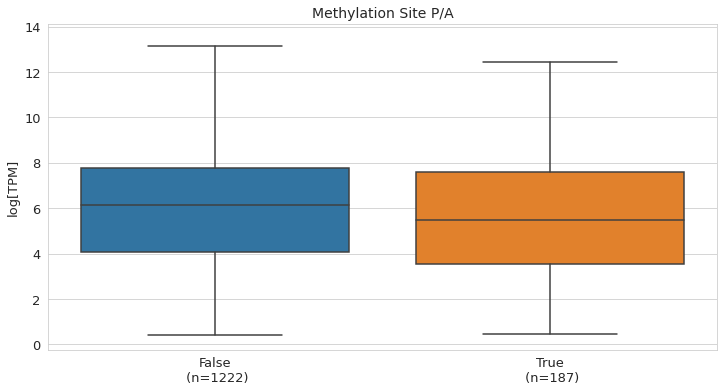

In [30]:
_, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='tu_gatc', y='log_tpm', data=gene_table_ml, fliersize=0, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('log[TPM]', fontsize=13)
ax.set_title(f"Methylation Site P/A", fontsize=14)
ax.set_xticklabels([
    f"{lab.get_text()}\n (n={n})"
    for lab, n in zip(ax.get_xticklabels(), gene_table_ml['tu_gatc'].value_counts().to_list())
]);

## Order in TU

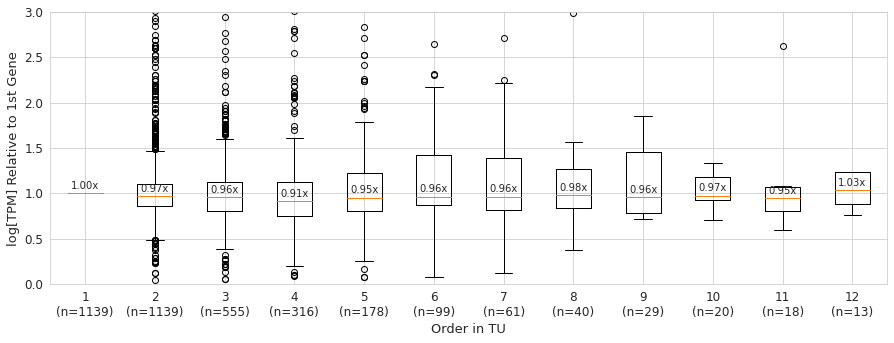

In [31]:
tu_rel_exps = {}

for tu_row in mg1655.tu_table.itertuples():

    tu_genes = mg1655._tu_to_genes[tu_row.Index]
    tu_gene_df = mg1655.gene_table[mg1655.gene_table.index.isin(tu_genes)].dropna(subset=['log_tpm'])

    if tu_gene_df.shape[0] > 1:
        
        if tu_row.strand == 1:
            sorted_gene_df = tu_gene_df.sort_values(by='left')
        else:
            sorted_gene_df = tu_gene_df.sort_values(by='right', ascending=False)
        
        tu_gene_exps_rel = np.array(sorted_gene_df['log_tpm']) / sorted_gene_df['log_tpm'][0]
        
        for i, rel_exp in enumerate(tu_gene_exps_rel):
            if i in tu_rel_exps:
                tu_rel_exps[i].append(rel_exp)
            else:
                tu_rel_exps[i] = [rel_exp]
                
tu_rel_exps = {k: v for k, v in tu_rel_exps.items() if len(v) > 10}

_, ax = plt.subplots(figsize=(15, 5))

ax.boxplot(list(tu_rel_exps.values()))
ax.set_xticklabels([f'{i+1}\n(n={len(vals)})' for i, vals in enumerate(tu_rel_exps.values())])
ax.set_xlabel('Order in TU', fontsize=13)
ax.set_ylabel('log[TPM] Relative to 1st Gene', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(bottom=0, top=3)
for i, vals in enumerate(tu_rel_exps.values()):
    med = np.median(vals)
    ax.text(i+1, med+0.05, f'{med:.2f}x', ha='center')

## Distance to TSS

(0.0, 3.0)

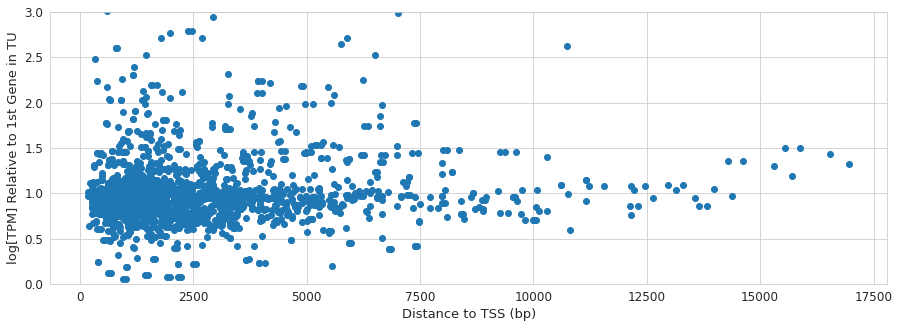

In [32]:
all_tss_dists = []
all_rel_exps_tss = []

for tu_row in mg1655.tu_table.itertuples():
    tu_genes = mg1655._tu_to_genes[tu_row.Index]
    tu_gene_df = mg1655.gene_table[mg1655.gene_table.index.isin(tu_genes)].dropna(subset=['log_tpm'])
    if tu_gene_df.shape[0] > 1:
        
        if tu_row.strand == 1:
            sorted_gene_df = tu_gene_df.sort_values(by='left')
            tss_dists = sorted_gene_df['left'].values - tu_row.tss
        else:
            sorted_gene_df = tu_gene_df.sort_values(by='right', ascending=False)
            tss_dists = tu_row.tss - sorted_gene_df['right']
        
        tu_gene_exps_rel = np.array(sorted_gene_df['log_tpm']) / sorted_gene_df['log_tpm'][0]
        
        # ignore the first gene in the TU, this will just give us a bunch of y-values of 1 
        all_tss_dists += list(tss_dists[1:])
        all_rel_exps_tss += list(tu_gene_exps_rel[1:])
        
_, ax = plt.subplots(figsize=(15, 5))

ax.scatter(all_tss_dists, all_rel_exps_tss)
ax.set_xlabel('Distance to TSS (bp)', fontsize=13)
ax.set_ylabel('log[TPM] Relative to 1st Gene in TU', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(0, 3)

## TU Length

Text(0, 0.5, 'log[TPM]')

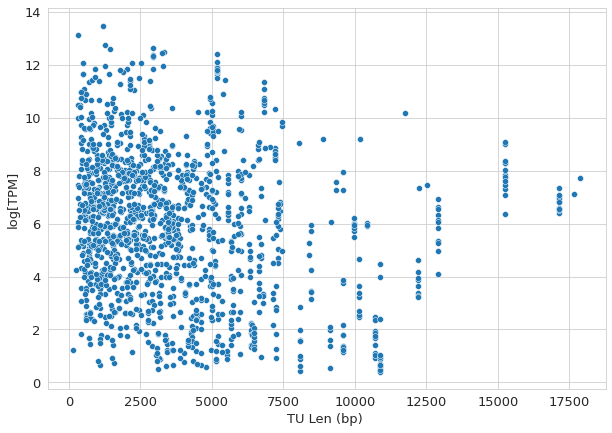

In [33]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='tu_len', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("TU Len (bp) ", fontsize=13)
ax.set_ylabel('log[TPM]', fontsize=13)

## TU GC Content

Text(0, 0.5, 'log[FPKM]')

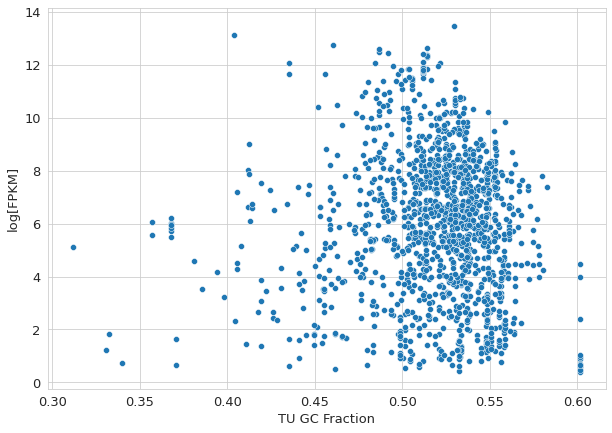

In [34]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='tu_gc', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("TU GC Fraction", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)

Show this as a histogram, or something?

## TSS Base

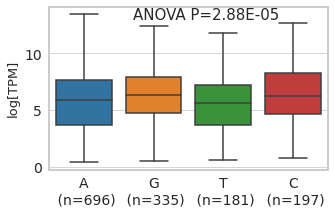

In [35]:
sns.set_style('whitegrid')

exp_groups = []
for tss_base, gloc_df in gene_table_ml.groupby('tss_base'):
    exp_groups.append(gloc_df['log_tpm'])
    
f, p = f_oneway(*exp_groups)

_, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(x='tss_base', y='log_tpm', data=gene_table_ml, fliersize=0, ax=ax)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('')
ax.set_ylabel('log[TPM]', fontsize=13)
#ax.set_title(f"TSS Base (ANOVA P={p:.2E})", fontsize=14)
ax.text(0.3, 0.92, f"ANOVA P={p:.2E}", fontsize=15, transform=ax.transAxes)
ax.set_xticklabels([
    f"{lab.get_text()}\n (n={gene_table_ml[gene_table_ml['tss_base'] == lab.get_text()].shape[0]})"
    for lab in ax.get_xticklabels()
]);
for s in ax.spines.values():
    s.set_linewidth(2)
plt.savefig('expression_ml_figures/tss_base.svg')

## 5' UTR 

### Length

(0.0, 400.0)

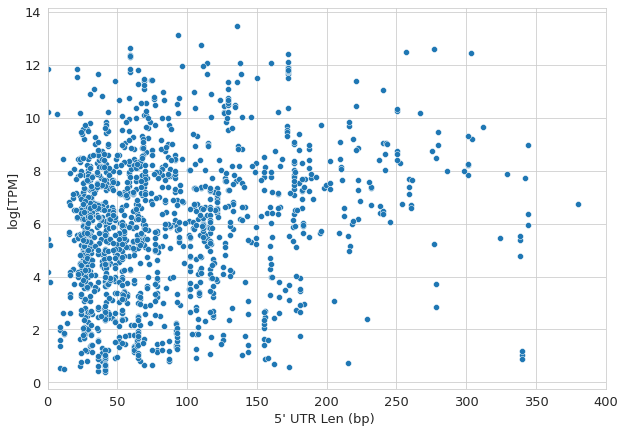

In [36]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='utr_len', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("5' UTR Len (bp) ", fontsize=13)
ax.set_ylabel('log[TPM]', fontsize=13)
ax.set_xlim(0, 400)

### GC Content

Text(0, 0.5, 'log[TPM]')

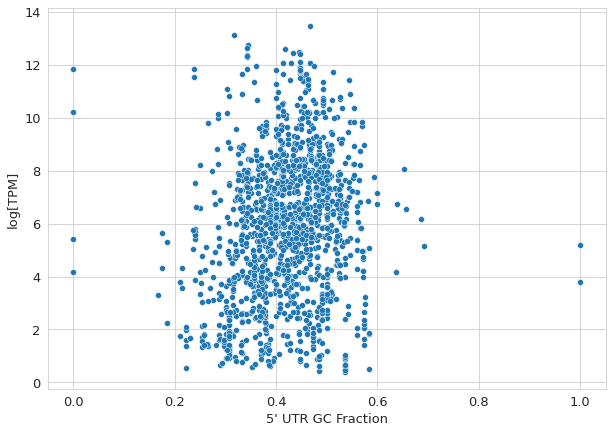

In [37]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='utr_gc', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("5' UTR GC Fraction", fontsize=13)
ax.set_ylabel('log[TPM]', fontsize=13)

## -10 Box

### Sequence

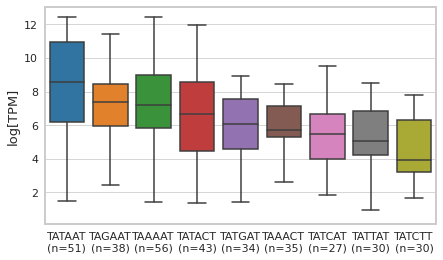

In [38]:
box_df = gene_table_ml[['box_10_seq', 'log_tpm']].dropna()

box_10_dfs = []

cutoff = 25
for _, b10seq_df in box_df.groupby('box_10_seq'):
    if b10seq_df.shape[0] > cutoff:
        box_10_dfs.append(b10seq_df)
        
box_10_dfs = sorted(box_10_dfs, key=lambda df: df['log_tpm'].median(), reverse=True)
box_10_df = pd.concat(box_10_dfs)

_, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(x='box_10_seq', y='log_tpm', data=box_10_df, fliersize=0, ax=ax)
#sns.swarmplot(x='box_10_seq', y='log_tpm', data=box_10_df, ax=ax)
ax.tick_params(axis='both', labelsize=11)
ax.set_xlabel('')
ax.set_ylabel('log[TPM]', fontsize=13)
ax.set_xticklabels([f"{lab.get_text()}\n(n={box_10_df[box_10_df['box_10_seq'] == lab.get_text()].shape[0]})"
                   for lab in ax.get_xticklabels()]);
# ax.set_title(f"-10 Box Sequence (n={len(box_df['box_10_seq'].unique())}; {len(box_10_dfs)} with >{cutoff} genes shown)",
#              fontsize=14)
for s in ax.spines.values():
    s.set_linewidth(2)
plt.savefig('expression_ml_figures/box_10.svg')

### Distance to TSS

Text(0, 0.5, 'log[TPM]')

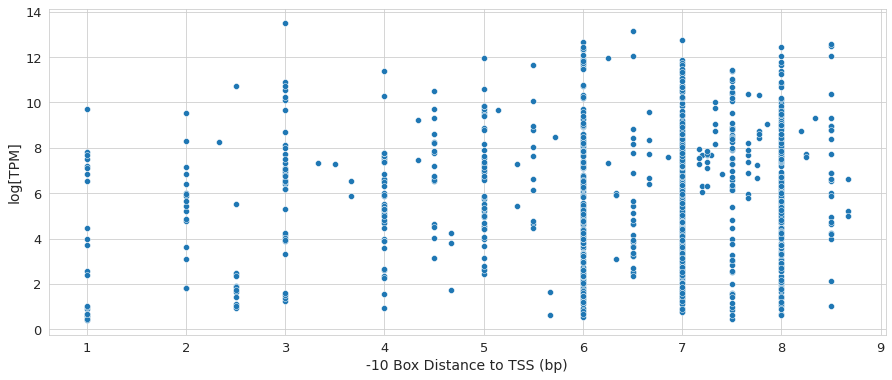

In [39]:
box_dist_df = gene_table_ml[['box_10_tss_dist', 'log_tpm']].dropna()
box_dist_df = box_dist_df[box_dist_df['box_10_tss_dist'] < 9]

_, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='box_10_tss_dist', y='log_tpm', data=box_dist_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-10 Box Distance to TSS (bp)', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

### Extended Box GC Content

Text(0, 0.5, 'log[TPM]')

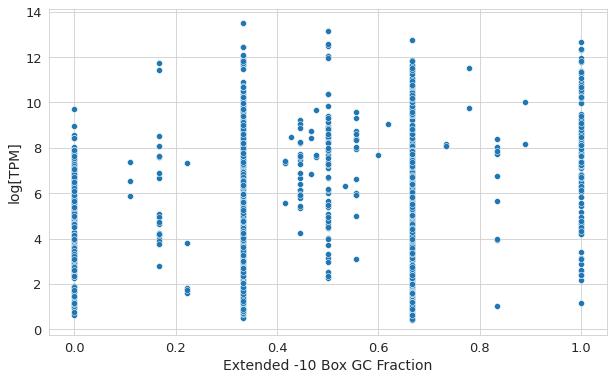

In [40]:
_, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='box_10_ext_gc', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Extended -10 Box GC Fraction', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

## -35 Box

### Sequence

Text(0.5, 1.0, '-35 Box Sequence (n=377; 5 with >20 genes shown)')

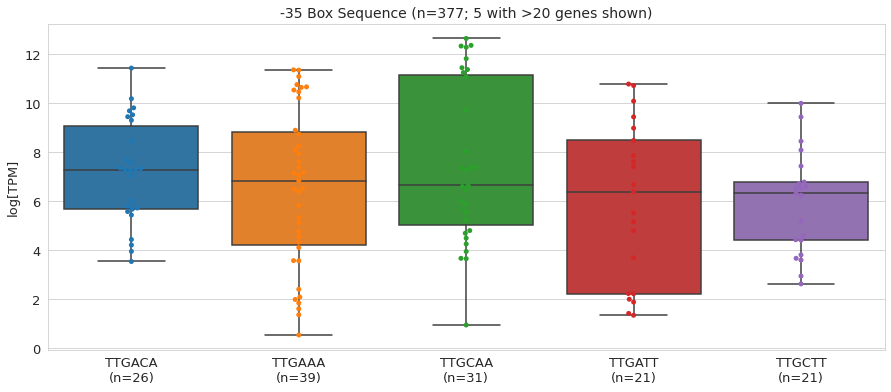

In [41]:
box_35_df_orig = gene_table_ml[['box_35_seq', 'log_tpm']].dropna()

box_35_dfs = []

cutoff = 20
for _, b35seq_df in box_35_df_orig.groupby('box_35_seq'):
    if b35seq_df.shape[0] > cutoff:
        box_35_dfs.append(b35seq_df)
        
box_35_dfs = sorted(box_35_dfs, key=lambda df: df['log_tpm'].median(), reverse=True)
box_35_df = pd.concat(box_35_dfs)

_, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='box_35_seq', y='log_tpm', data=box_35_df, fliersize=0, ax=ax)
sns.swarmplot(x='box_35_seq', y='log_tpm', data=box_35_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('log[TPM]', fontsize=13)
ax.set_xticklabels([f"{lab.get_text()}\n(n={box_35_df[box_35_df['box_35_seq'] == lab.get_text()].shape[0]})"
                   for lab in ax.get_xticklabels()])
ax.set_title(f"-35 Box Sequence (n={len(box_35_df_orig['box_35_seq'].unique())}; {len(box_35_dfs)} with >{cutoff} genes shown)",
             fontsize=14)

### Distance to TSS

Text(0, 0.5, 'log[TPM]')

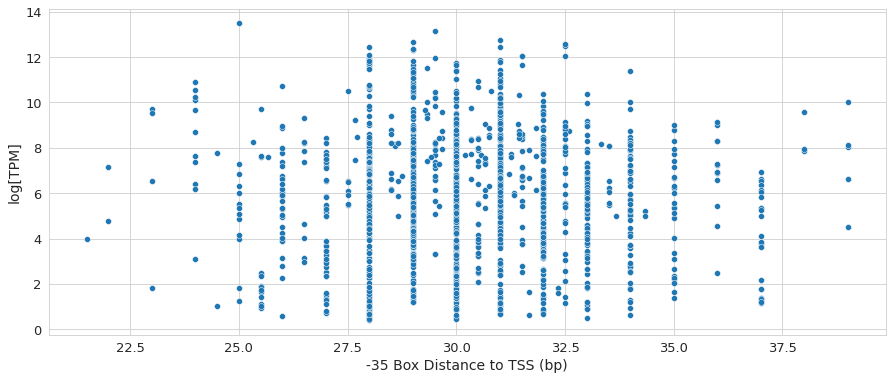

In [42]:
box_dist_df = gene_table_ml[['box_35_tss_dist', 'log_tpm']].dropna()

_, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='box_35_tss_dist', y='log_tpm', data=box_dist_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-35 Box Distance to TSS (bp)', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

## Spacer

### Length

Text(0, 0.5, 'log[TPM]')

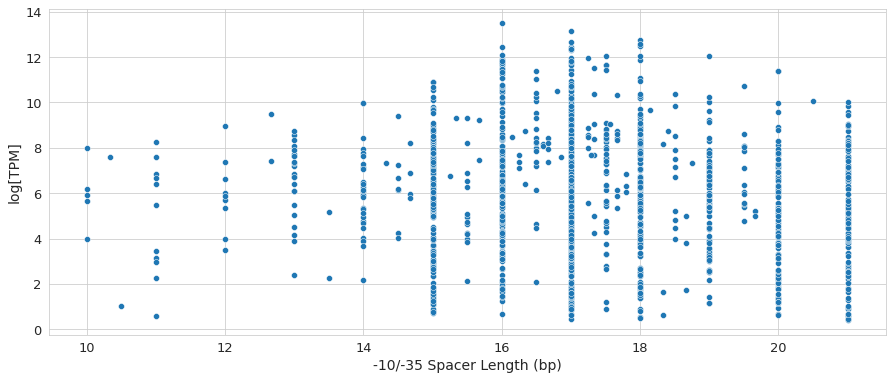

In [43]:
_, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='spacer_len', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-10/-35 Spacer Length (bp)', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

### GC Content

Text(0, 0.5, 'log[TPM]')

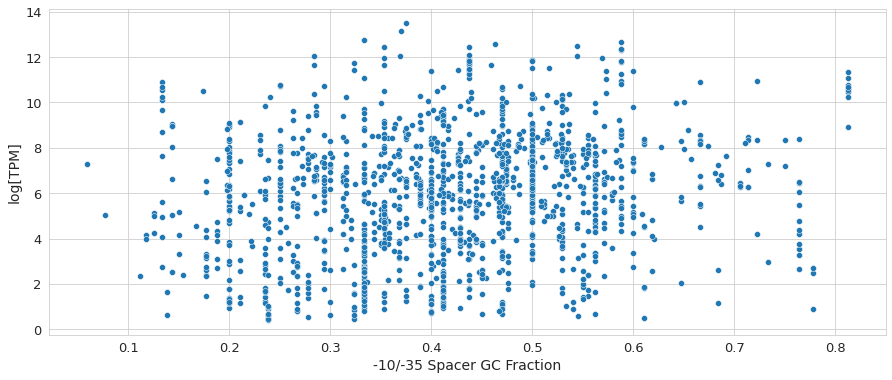

In [44]:
_, ax = plt.subplots(figsize=(15, 6))
sns.scatterplot(x='spacer_gc', y='log_tpm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-10/-35 Spacer GC Fraction', fontsize=14)
ax.set_ylabel('log[TPM]', fontsize=14)

## Regulatory Effect

Text(0.5, 1.0, 'MG1655 Expression by Regulatory Effect (P = 2.301E-12)')

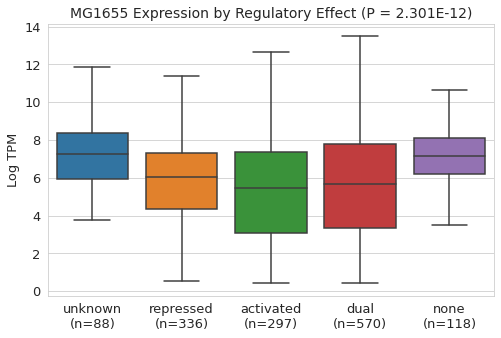

In [45]:
reg_effect_df = gene_table_ml.copy()
reg_effect_df['reg_effect'] = reg_effect_df['reg_effect'].fillna('none')

loc_groups = []
for loc, gloc_df in reg_effect_df.groupby('reg_effect'):
    loc_groups.append(gloc_df['log_tpm'])
    
f, p = f_oneway(*loc_groups)

_, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(x='reg_effect', y='log_tpm',
            data=reg_effect_df, fliersize=0, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_xticklabels([f"{lab.get_text()}\n(n={reg_effect_df[reg_effect_df['reg_effect'] == lab.get_text()].shape[0]})"
                       for lab in ax.get_xticklabels()])    
ax.set_ylabel('Log TPM', fontsize=13)
ax.set_title(f'MG1655 Expression by Regulatory Effect (P = {p:.3E})', fontsize=14)

# Circos

## Write Log TPM File

In [46]:
with open('/Users/cam/bin/circos/circos-0.69-9/expression_ml/log_tpm.txt', 'w') as file:
    for gene_row in gene_table_ml.itertuples():
        if pd.notna(gene_row.log_tpm):
            if gene_row.rep_region in ['leading', 'terminus']:
                log_tpm = gene_row.log_tpm
            else:
                log_tpm = gene_row.log_tpm * -1
            file.write(f'ec1 {gene_row.left} {gene_row.right} {log_tpm}\n')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/cam/bin/circos/circos-0.69-9/expression_ml/log_tpm.txt'

## Write CIDs

In [ ]:
with open('/Users/cam/bin/circos/circos-0.69-9/expression_ml/cid_bounds.txt', 'w') as file:
    plus_minus = 1000
    for cid_bound in mg1655.cid_boundaries:
        file.write(f'ec1 {cid_bound - plus_minus} {cid_bound + plus_minus}\n')

## Essential Genes

In [ ]:
with open('/Users/cam/bin/circos/circos-0.69-9/expression_ml/highlights_essential.txt', 'w') as file:
    for gene_row in gene_table_ml.itertuples():
        if not pd.isna(gene_row.essential):
            file.write(f'ec1 {gene_row.left} {gene_row.right}\n')

## y-ome

In [ ]:
with open('/Users/cam/bin/circos/circos-0.69-9/expression_ml/highlights_yome.txt', 'w') as file:
    for _, gene_row in gene_table_ml.iterrows():
        if gene_row['y-ome'] == 'y-ome':
            file.write(f'ec1 {gene_row.left} {gene_row.right}\n')

# Modeling - Genome Organization Features

## Prepare Feature Matrices

There are too many distinct -35/-10 sequences to use these as categories; so let's sneakily one-hot encode them. Might add this to the function later.

In [ ]:
X = gene_table_ml.drop(columns=['left', 'right', 'strand', 'pseudo', 'name', 'cog', 'essential',
                               'y-ome', 'tpm_ctrl', 'tpm_all', 'log_tpm']).dropna()
y_go = X['tpm']
X = X.drop(columns=['tpm'])

def box_to_oh(box_seq, box):
    # not using pandas' get_dummies method ensures that we account for sequences that don't
    # have all 4 nucleotides, and also allows us to prepare a 1-dimensional one-hot vector
    one_hot_names = []
    one_hots = []
    for i, seq_base in enumerate(box_seq):
        for base in 'ACGT':
            one_hot_names.append(f'{box}_{i+1}_{base}')
            if base == seq_base:
                one_hots.append(1)
            else:
                one_hots.append(0)

    one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
    return one_hot_sequence
    
box_10_oh_df = X['box_10_seq'].apply(lambda box_10_seq: box_to_oh(box_10_seq, '-10'))
box_35_oh_df = X['box_35_seq'].apply(lambda box_35_seq: box_to_oh(box_35_seq, '-35'))

X_all = pd.get_dummies(
    pd.concat([X, box_10_oh_df, box_35_oh_df], axis=1).drop(columns=['box_10_seq', 'box_35_seq']))
X_no_b10 = pd.get_dummies(
    pd.concat([X, box_35_oh_df], axis=1).drop(columns=['box_10_seq', 'box_35_seq']))
X_no_b35 = pd.get_dummies(
    pd.concat([X, box_10_oh_df], axis=1).drop(columns=['box_10_seq', 'box_35_seq']))
X_no_boxes = pd.get_dummies(X.drop(columns=['box_10_seq', 'box_35_seq', 'cid']))
X_no_spacer_gc = pd.get_dummies(X.drop(columns=['box_10_seq', 'box_35_seq', 'cid', 'spacer_gc']))

# add models missing -10, OR -35 information
Xy_to_try_go = {
    'all': (X_all, y_go),
    'no_b10': (X_no_b10, y_go),
    'no_b35': (X_no_b35, y_go),
    'no_boxes': (X_no_boxes, y_go), 
    'no_spacer_gc': (X_no_spacer_gc, y_go)
}

## Set Aside Lockbox Data

In [ ]:
Xy_train_go['no_boxes'][0].shape

In [ ]:
Xy_train_go, Xy_lockbox_go = create_train_and_lockbox_sets(Xy_to_try_go, random_state=42)

## Profile Models

In [ ]:
models_to_try = {
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'DTree': DecisionTreeRegressor(max_depth=5),
    'RF': RandomForestRegressor(n_jobs=4)
    #'NN': MLPRegressor()
}

In [ ]:
profile_xy_and_models(Xy_train_go, models_to_try, scoring='r2', n_cv=8,
                      x_preprocessing=['standard'], y_preprocessing=['log'],
                      verbose=True)

In [ ]:
Xy_train

## Feature Importances

### Random Forest

In [ ]:
x_go_fi_raw = Xy_train_go['no_boxes'][0]
x_go_fi = pd.DataFrame(
    StandardScaler().fit_transform(x_go_fi_raw),
    columns=x_go_fi_raw.columns,
    index=x_go_fi_raw.index
)
y_go_fi = np.log2(Xy_train_go['no_boxes'][1].values + 1)

feature_importance(x_go_fi, y_go_fi, models_to_try['RF'])

### SVR

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_go_fi, y_go_fi, test_size=0.2)
fit_model = models_to_try['SVR'].fit(x_train, y_train)

In [ ]:
explainer = shap.KernelExplainer(fit_model.predict, shap.sample(x_train, 200))
shap_values = explainer.shap_values(x_val, nsamples=100)

In [ ]:
shap.summary_plot(shap_values, x_val)

### Decision Tree

In [ ]:
feature_importance(x_go_fi, y_go_fi, models_to_try['DTree'])

## Predicted vs Actual

In [ ]:
sns.set_style('white')

# split and fit the data with the given model; generate predictions
x_train, x_val, y_train, y_val = train_test_split(x_go_fi, y_go_fi, test_size=0.2, random_state=35)
fit_model = models_to_try['RF'].fit(x_train, y_train)
y_pred = fit_model.predict(x_val)

r_squared = r2_score(y_val, y_pred)
pearson_r, pearson_p = pearsonr(y_val, y_pred)
spearman_r, spearman_p = spearmanr(y_val, y_pred)

_, ax = plt.subplots(figsize=(4, 4))
ax.scatter(y_val, y_pred)
ax.set_xlabel('log[TPM] (Actual)', fontsize=14)
ax.set_ylabel('log[TPM] (Predicted)', fontsize=14)
ax.plot([0, 1], [0, 1], linestyle='--', transform=ax.transAxes, color='black')
ax.tick_params(axis='both', labelsize=13)
ax.set_xticks([0, 5, 10])
ax.set_yticks([0, 5, 10])
#  (P={pearson_p:.2E})\nSpearman R: {spearman_r:.2f} (P={spearman_p:.2E}
text = f'R-squared: {r_squared:.2f}'
ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=14)
for s in ax.spines.values():
    s.set_linewidth(1.5)
plt.savefig('expression_ml_figures/parity_plot.svg', bbox_inches='tight')

In [ ]:
x_train

## Hyperoptimization

In [ ]:
X_go_hyperopt, y_go_hyperopt = Xy_train_go['no_boxes']

X_go_hyperopt = pd.DataFrame(
    StandardScaler().fit_transform(X_go_hyperopt),
    columns=X_go_hyperopt.columns,
    index=X_go_hyperopt.index)
y_go_hyperopt = np.log2(y_go_hyperopt + 1)

hyperopt_XY_go = {
    'no_boxes': (X_go_hyperopt, y_go_hyperopt)
}

In [ ]:
hyperopt_models = {
    'SVR': {
        'model': SVR(),
        'param_dists': {
            'C': np.logspace(-3, 3, 20),
            'tol': np.logspace(-6, -2, 10)
        }
    },
    'DTree': {
        'model': DecisionTreeRegressor(),
        'param_dists': {
            'max_depth': np.arange(2, 10),
            'criterion': ["mse", "friedman_mse", "mae", "poisson"],
            'splitter': ['best', 'random']
        }
    },
    'RF': {
        'model': RandomForestRegressor(max_depth=8, n_jobs=4),
        'param_dists': {
            'n_estimators': np.arange(10, 100)
        }
    }
}

In [ ]:
hyperopt_results = {}

for model_name, model_hyperopt_dict in hyperopt_models.items():

    hyperopt_results[model_name] = {}
    
    for X_name, (X, y) in hyperopt_XY_go.items():
        print(f'{model_name}: {X_name}')

        random_search_hyperopt = RandomizedSearchCV(
            model_hyperopt_dict['model'],
            model_hyperopt_dict['param_dists'],
            n_iter=50,
            scoring='r2',
            n_jobs=4,
            cv=5,
            verbose=3,
            return_train_score=True
        )

        random_search_hyperopt.fit(X, y)

        hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
            by='mean_test_score',
            ascending=False
        )
        hyperopt_results[model_name][X_name] = hyperopt_results_df

In [ ]:
hyperopt_result_df = hyperopt_results['SVR']['no_boxes']
hyperopt_result_df = hyperopt_result_df[hyperopt_result_df['mean_test_score'] > 0.3]
hyperopt_result_df['overfit'] = hyperopt_result_df['mean_train_score'] - hyperopt_result_df['mean_test_score']
hyperopt_result_df.sort_values(by='overfit')[[
    'param_C',
    'mean_test_score', 'mean_train_score', 'overfit'
]]

# Outliers

## Parity Plot

Let's look at outliers with an SVR

In [ ]:
x_go_outliers_raw = Xy_train_go['no_boxes'][0]
x_go_outliers = pd.DataFrame(
    StandardScaler().fit_transform(x_go_fi_raw),
    columns=x_go_fi_raw.columns,
    index=x_go_fi_raw.index
)
y_go_outliers = pd.Series(np.log2(Xy_train_go['no_boxes'][1].values + 1), index=Xy_train_go['no_boxes'][1].index)

In [ ]:
# split and fit the data with the given model; generate predictions
x_train, x_val, y_train, y_val = train_test_split(x_go_outliers, y_go_outliers, test_size=0.2, random_state=40)
outlier_model = SVR(C=1.4)
fit_model = outlier_model.fit(x_train, y_train)
y_pred = pd.Series(fit_model.predict(x_val), index=y_val.index)

r_squared = r2_score(y_val, y_pred)
pearson_r, pearson_p = pearsonr(y_val, y_pred)
spearman_r, spearman_p = spearmanr(y_val, y_pred)

_, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val, y_pred)
ax.set_xlabel('log[TPM] (Actual)', fontsize=14)
ax.set_ylabel('log[TPM] (Predicted)', fontsize=14)
ax.plot([0, 1], [0, 1], linestyle='--', transform=ax.transAxes)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('Classical Parity Plot', fontsize=16)
text = f'R-square: {r_squared:.2f}\nPearson R: {pearson_r:.2f} (P={pearson_p:.2E})\nSpearman R: {spearman_r:.2f} (P={spearman_p:.2E})'
ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=14)

## Find Robust Outliers

In [ ]:
log_tpm_diff_dict = {}

for i in tqdm(np.arange(0, 1000, 5)):
    
    # split and fit the data with the given model; generate predictions
    x_train, x_val, y_train, y_val = train_test_split(x_go_outliers, y_go_outliers, test_size=0.2, random_state=i)
    outlier_model = SVR(C=1.4)
    outlier_model.fit(x_train, y_train)
    y_pred = pd.Series(outlier_model.predict(x_val), index=y_val.index)
    
    for gene_id, g_pred, g_val in zip(y_pred.index, y_pred, y_val):
        if gene_id in log_tpm_diff_dict:
            log_tpm_diff_dict[gene_id].append((g_pred, g_val))
        else:
            log_tpm_diff_dict[gene_id] = [(g_pred, g_val)]

In [ ]:
plt.hist([len(vals) for vals in log_tpm_diff_dict.values()])

In [ ]:
log_tpm_diff_df = pd.DataFrame(
    data={
        'pred_mean': [np.mean([tup[0] for tup in tpm_tups]) for tpm_tups in log_tpm_diff_dict.values()],
        'pred_std': [np.std([tup[0] for tup in tpm_tups]) for tpm_tups in log_tpm_diff_dict.values()],
        'actual': [np.mean([tup[1] for tup in tpm_tups]) for tpm_tups in log_tpm_diff_dict.values()]
    },
    index=list(log_tpm_diff_dict.keys())
)
log_tpm_diff_df['diff_mean'] = log_tpm_diff_df['pred_mean'] - log_tpm_diff_df['actual']
log_tpm_diff_df = log_tpm_diff_df.sort_values(by='diff_mean', ascending=False)
log_tpm_diff_df

In [ ]:
_, ax = plt.subplots()

sns.histplot(x='diff_mean', data=log_tpm_diff_df)
ax.set_xlabel('Predicted - Actual Expression (log[TPM])', fontsize=13)
ax.set_ylabel('# of Genes', fontsize=13)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Distribution of Model Absolute Errors (n={log_tpm_diff_df.shape[0]})', fontsize=15)

In [ ]:
_, ax = plt.subplots()

sns.histplot(x='pred_std', data=log_tpm_diff_df)
ax.set_xlabel('SD of Expression Prediction (log[TPM])', fontsize=13)
ax.set_ylabel('# of Genes', fontsize=13)
ax.tick_params(axis='both', labelsize=13)
ax.set_title(f'Model Prediction Variance (n={log_tpm_diff_df.shape[0]})', fontsize=15)

## Prediction Way too High

### Force Plots

In [ ]:
high_pred_outliers = log_tpm_diff_df[log_tpm_diff_df['diff_mean'] > 4]
high_pred_gene_info = high_pred_outliers.merge(gene_table_ml, how='left', left_index=True, right_index=True)

# make a validation set that definitely has these genes in it so we can make force plots
x_go_outliers_high = x_go_outliers.copy().drop(index=high_pred_gene_info.index)
y_go_outliers_high = y_go_outliers.copy().drop(index=high_pred_gene_info.index)
x_train_high, x_val_high, y_train_high, y_val_high = train_test_split(
    x_go_outliers_high, y_go_outliers_high, test_size=0.2, random_state=5656
)
x_val_high = x_val_high.append(x_go_outliers.loc[high_pred_gene_info.index])
y_val_high = y_val_high.append(y_go_outliers.loc[high_pred_gene_info.index])

outlier_model_high = SVR(C=1.4)
outlier_model_high.fit(x_train_high, y_train_high)
y_pred = pd.Series(outlier_model_high.predict(x_val_high), index=y_val_high.index)

explainer_high = shap.KernelExplainer(outlier_model_high.predict, shap.sample(x_train_high, 200))
shap_values_high = explainer_high.shap_values(x_val_high, nsamples=200)

r_squared = r2_score(y_val_high, y_pred)
pearson_r, pearson_p = pearsonr(y_val_high, y_pred)
spearman_r, spearman_p = spearmanr(y_val_high, y_pred)

_, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val_high, y_pred)
ax.set_xlabel('log[TPM] (Actual)', fontsize=14)
ax.set_ylabel('log[TPM] (Predicted)', fontsize=14)
ax.plot([0, 1], [0, 1], linestyle='--', transform=ax.transAxes)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('Classical Parity Plot', fontsize=16)
text = f'R-square: {r_squared:.2f}\nPearson R: {pearson_r:.2f} (P={pearson_p:.2E})\nSpearman R: {spearman_r:.2f} (P={spearman_p:.2E})'
ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=14);

In [ ]:
n_high_outliers = high_pred_gene_info.shape[0]

shap.force_plot(
    explainer_high.expected_value,
    shap_values_high[-n_high_outliers:,:],
    x_val_high.iloc[-n_high_outliers:,:]
)

In [ ]:
shap.force_plot(
    explainer_high.expected_value,
    shap_values_high[-n_high_outliers,:],
    x_val_high.iloc[-n_high_outliers,:]
)

### Manual Investigation

In [ ]:
idx = 13

In [ ]:
info_row = pd.DataFrame(high_pred_gene_info.iloc[idx, :]).T
info_row

In [ ]:
gene_tu = mg1655._gene_to_tus[info_row.index[0]][0]
gene_tss = mg1655.tu_table.loc[gene_tu, 'tss']
if mg1655.tu_table.loc[gene_tu, 'strand'] == 1:
    l, r = gene_tss - 50, gene_tss + 25
else:
    l, r = gene_tss - 25, gene_tss + 50
mg1655.view_region(l, r)

## Prediction Way too Low

### Force Plots

In [ ]:
low_pred_outliers = log_tpm_diff_df[log_tpm_diff_df['diff_mean'] < -4]
low_pred_gene_info = low_pred_outliers.merge(gene_table_ml, how='left', left_index=True, right_index=True)

# make a validation set that definitely has these genes in it so we can make force plots
x_go_outliers_low = x_go_outliers.copy().drop(index=low_pred_gene_info.index)
y_go_outliers_low = y_go_outliers.copy().drop(index=low_pred_gene_info.index)
x_train_low, x_val_low, y_train_low, y_val_low = train_test_split(
    x_go_outliers_low, y_go_outliers_low, test_size=0.2, random_state=5656
)
x_val_low = x_val_low.append(x_go_outliers.loc[low_pred_gene_info.index])
y_val_low = y_val_low.append(y_go_outliers.loc[low_pred_gene_info.index])

outlier_model_low = SVR(C=1.4)
outlier_model_low.fit(x_train_low, y_train_low)
y_pred_low = pd.Series(outlier_model_low.predict(x_val_low), index=y_val_low.index)

explainer_low = shap.KernelExplainer(outlier_model_low.predict, shap.sample(x_train_low, 200))
shap_values_low = explainer_low.shap_values(x_val_low, nsamples=200)

r_squared = r2_score(y_val_low, y_pred_low)
pearson_r, pearson_p = pearsonr(y_val_low, y_pred_low)
spearman_r, spearman_p = spearmanr(y_val_low, y_pred_low)

_, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val_low, y_pred_low)
ax.set_xlabel('log[TPM] (Actual)', fontsize=14)
ax.set_ylabel('log[TPM] (Predicted)', fontsize=14)
ax.plot([0, 1], [0, 1], linestyle='--', transform=ax.transAxes)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('Classical Parity Plot', fontsize=16)
text = f'R-square: {r_squared:.2f}\nPearson R: {pearson_r:.2f} (P={pearson_p:.2E})\nSpearman R: {spearman_r:.2f} (P={spearman_p:.2E})'
ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=14);

In [ ]:
n_low_outliers = low_pred_gene_info.shape[0]

shap.force_plot(
    explainer_low.expected_value,
    shap_values_low[-n_low_outliers:,:],
    x_val_low.iloc[-n_low_outliers:,:]
)

### Manual Investigation

In [ ]:
idx_low = 1

In [ ]:
info_row_low = pd.DataFrame(low_pred_gene_info.iloc[idx_low, :]).T
info_row_low

In [ ]:
gene_tu_low = mg1655._gene_to_tus[info_row_low.index[0]][0]
gene_tss_low = mg1655.tu_table.loc[gene_tu_low, 'tss']
if mg1655.tu_table.loc[gene_tu_low, 'strand'] == 1:
    l, r = gene_tss_low - 50, gene_tss_low + 25
else:
    l, r = gene_tss_low - 25, gene_tss_low + 50
mg1655.view_region(l, r)

In [ ]:
shap.force_plot(
    explainer_low.expected_value,
    shap_values_low[-n_low_outliers+idx_low,:],
    x_val_low.iloc[-n_low_outliers+idx_low,:]
)

# Feature Correlations

In [ ]:
feat_corr_df = X_all.corr()
_, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(feat_corr_df, ax=ax)

In [ ]:
feat_corr_bin = feat_corr_df[feat_corr_df.abs() > 0.5]
_, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(feat_corr_bin, ax=ax)

In [ ]:
corr_pairs = []
for i in range(feat_corr_bin.shape[0]):
    for j in range(feat_corr_bin.shape[0]):
        if i > j and not pd.isna(feat_corr_bin.iloc[i, j]):
            corr_pairs.append((feat_corr_bin.columns[i], feat_corr_bin.columns[j]))
corr_pairs

# Reduced Feature Sets

## Prepare Features/Lockbox

In [ ]:
x_go_fi_red_raw = Xy_train_go['no_boxes'][0]
x_go_fi_red = pd.DataFrame(
    StandardScaler().fit_transform(x_go_fi_red_raw),
    columns=x_go_fi_red_raw.columns,
    index=x_go_fi_red_raw.index
)
y_go_red = np.log2(Xy_train_go['all'][1].values + 1)

x_train_red, x_val_red, y_train_red, y_val_red = train_test_split(x_go_fi_red, y_go_red, test_size=0.2)
fit_model = models_to_try['RF'].fit(x_train_red, y_train_red)
explainer = shap.TreeExplainer(fit_model)
shap_values = explainer.shap_values(x_val_red)
sorted_shaps, sorted_feats = zip(*sorted(zip(np.abs(shap_values).mean(axis=0), x_val_red.columns),
                                   key=lambda tup: tup[0], reverse=True))

In [ ]:
models_to_try = {
    'SVR': SVR(C=1.5),
    'RF': RandomForestRegressor(n_estimators=20, max_depth=10, n_jobs=4),
    'DecisionTree': DecisionTreeRegressor(max_depth=6)
}

x_go_fi_red_raw = Xy_train_go['no_boxes'][0]
x_go_fi_red = pd.DataFrame(
    StandardScaler().fit_transform(x_go_fi_red_raw),
    columns=x_go_fi_red_raw.columns,
    index=x_go_fi_red_raw.index
)
y_go_red = np.log2(Xy_train_go['no_boxes'][1].values + 1)

x_train_red, x_val_red, y_train_red, y_val_red = train_test_split(x_go_fi_red, y_go_red, test_size=0.2)

## Profile Models

In [ ]:
result_dict = {}

for model_name, model in models_to_try.items():
    
    # train the model on the no_boxes dataset so we can get feature importance
    fit_model = model.fit(x_train_red, y_train_red)
    if model_name in ['DTree', 'RF']:
        explainer = shap.TreeExplainer(fit_model)
        shap_values = explainer.shap_values(x_val_red)
    else:
        explainer = shap.KernelExplainer(fit_model.predict, shap.sample(x_train_red, 200))
        shap_values = explainer.shap_values(x_val_red, nsamples=100)
    sorted_shaps, sorted_feats = zip(*sorted(zip(np.abs(shap_values).mean(axis=0), x_val_red.columns),
                                       key=lambda tup: tup[0], reverse=True))
    
    Xy_go_red_imp = {}

    n_features = [2, 3, 4, 5, 6, 8, 10, 15, 20, 23]

    for n in n_features:
        cols_to_use = list(sorted_feats)[:n]
        X_red_imp = X_all[cols_to_use]
        Xy_go_red_imp[f'{model_name}_{n}_top_feats'] = (X_red_imp, y_go)
        
    Xy_train_go_red_imp, Xy_lockbox_go_red_imp = create_train_and_lockbox_sets(Xy_go_red_imp, random_state=42)
    
    model_profile_df, ax_train, ax_val = profile_xy_and_models(
        Xy_train_go_red_imp, {model_name: model}, scoring='r2',n_cv=5,
        x_preprocessing=['standard'], y_preprocessing=['log'], verbose=False)
    result_dict[model_name] = model_profile_df

In [ ]:
model_profile_df = result_dict['SVR']
to_plot_df = model_profile_df[
    (model_profile_df['xy'].str.contains('X_standard')) & 
    (model_profile_df['xy'].str.contains('y_log'))
]

_, (ax_train, ax_val) = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(x='xy', y='train_score', data=to_plot_df, dodge=True,
            fliersize=0, ax=ax_train)
ax_train.set_xlabel('')
x_labs = ax_train.get_xticklabels()
x_labs_new = [f"{lab.get_text().split('__')[0]}" for lab in x_labs]
ax_train.set_xticklabels(x_labs_new, rotation=90)
ax_train.set_yticks(np.arange(0, 1.1, 0.1))
ax_train.set_ylabel(f'Training R-squared', fontsize=13)
ax_train.set_ylim(0, 1)

sns.boxplot(x='xy', y='val_score', data=to_plot_df, dodge=True,
            fliersize=0, ax=ax_val)
handles_val, labels_val = ax_val.get_legend_handles_labels()
ax_val.set_xlabel('')
x_labs = ax_val.get_xticklabels()
x_labs_new = [f"{lab.get_text().split('__')[0]}" for lab in x_labs]
ax_val.set_xticklabels(x_labs_new, rotation=90)
ax_val.set_yticks(np.arange(0, 1.1, 0.1))
ax_val.set_ylabel(f'Validation R-squared', fontsize=13)
ax_val.set_ylim(0, 1)

sns.set_style('whitegrid')
plt.tight_layout()

## Hyperoptimize

How much performance can we get from these top 4 features?

In [ ]:
X_red_hyp, y_red_hyp = Xy_train_go_red_imp['SVR_5_top_feats']

X_red_hyp = pd.DataFrame(
    StandardScaler().fit_transform(X_red_hyp),
    columns=X_red_hyp.columns,
    index=X_red_hyp.index)
y_red_hyp = np.log2(y_red_hyp + 1)

hyperopt_XY_red = {
    '5_top_feats': (X_red_hyp, y_red_hyp)
}

In [ ]:
hyperopt_models = {
    'SVR': {
        'model': SVR(),
        'param_dists': {
            'C': np.logspace(-3, 2, 20),
            'tol': np.logspace(-6, -2, 10)
        }
    },
    'RF': {
        'model': RandomForestRegressor(n_jobs=4),
        'param_dists': {
            'n_estimators': np.arange(10, 50),
            'max_depth': np.arange(2, 8)
        }
    }
}

In [ ]:
hyperopt_results = {}

for model_name, model_hyperopt_dict in hyperopt_models.items():

    hyperopt_results[model_name] = {}
    
    for X_name, (X, y) in hyperopt_XY_red.items():
        print(f'{model_name}: {X_name}')

        random_search_hyperopt = RandomizedSearchCV(
            model_hyperopt_dict['model'],
            model_hyperopt_dict['param_dists'],
            n_iter=50,
            scoring='r2',
            n_jobs=4,
            cv=5,
            verbose=3,
            return_train_score=True
        )

        random_search_hyperopt.fit(X, y)

        hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
            by='mean_test_score',
            ascending=False
        )
        hyperopt_results[model_name][X_name] = hyperopt_results_df

In [ ]:
hyperopt_result_df = hyperopt_results['SVR']['5_top_feats']
hyperopt_result_df = hyperopt_result_df[hyperopt_result_df['mean_test_score'] > 0.3]
hyperopt_result_df['overfit'] = hyperopt_result_df['mean_train_score'] - hyperopt_result_df['mean_test_score']
hyperopt_result_df.sort_values(by='overfit')[[
    'param_C', 'param_tol',
    'mean_test_score', 'mean_train_score', 'overfit'
]]

# Reduced Random Forest Model

## Prepare Feature Matrix

In [ ]:
feats_to_use = ['utr_gc', 'utr_len', 'tu_gc', 'tu_len']

X_rf_red, y_rf_red = Xy_train_go['no_boxes']
X_rf_red = X_rf_red[feats_to_use]
Xy_rf_red = {'utr/tu': (X_rf_red, y_rf_red)}

## Profile Model

In [ ]:
profile_xy_and_models(Xy_rf_red, {'RF': RandomForestRegressor(n_jobs=4)}, scoring='r2', n_cv=5,
                      x_preprocessing=['standard'], y_preprocessing=['log'],
                      verbose=True)

## Feature Importance

In [ ]:
x_rf_red_fi_raw = Xy_rf_red['utr/tu'][0]
x_rf_red_fi = pd.DataFrame(
    StandardScaler().fit_transform(x_rf_red_fi_raw),
    columns=x_rf_red_fi_raw.columns,
    index=x_rf_red_fi_raw.index
)
y_rf_red_fi = np.log2(Xy_rf_red['utr/tu'][1].values + 1)

feature_importance(x_rf_red_fi, y_rf_red_fi, RandomForestRegressor(n_jobs=4))

## Hyperoptimize

We want the simplest model possible

In [ ]:
hyperopt_XY_rf_red = {
    'utr/tu': (x_rf_red_fi, y_rf_red_fi)
}

In [ ]:
hyperopt_models = {
    'RF': {
        'model': RandomForestRegressor(n_jobs=4),
        'param_dists': {
            'n_estimators': np.arange(10, 100),
            'max_depth': np.arange(5, 8),
            'min_samples_split': np.arange(2, 10),
            'max_samples': np.arange(0.25, 1, 0.05)
        }
    }
}

In [ ]:
hyperopt_results = {}

for model_name, model_hyperopt_dict in hyperopt_models.items():

    hyperopt_results[model_name] = {}
    
    for X_name, (X, y) in hyperopt_XY_rf_red.items():
        print(f'{model_name}: {X_name}')

        random_search_hyperopt = RandomizedSearchCV(
            model_hyperopt_dict['model'],
            model_hyperopt_dict['param_dists'],
            n_iter=500,
            scoring='r2',
            n_jobs=4,
            cv=5,
            verbose=3,
            return_train_score=True
        )

        random_search_hyperopt.fit(X, y)

        hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
            by='mean_test_score',
            ascending=False
        )
        hyperopt_results[model_name][X_name] = hyperopt_results_df

In [ ]:
hyperopt_result_df = hyperopt_results['RF']['utr/tu']
hyperopt_result_df = hyperopt_result_df[hyperopt_result_df['mean_test_score'] > 0.2]
hyperopt_result_df['overfit'] = hyperopt_result_df['mean_train_score'] - hyperopt_result_df['mean_test_score']
hyperopt_result_df.sort_values(by='mean_test_score', ascending=False)[[
    'param_n_estimators', 'param_min_samples_split', 'param_max_samples', 'param_max_depth', 
    'mean_test_score', 'mean_train_score', 'overfit'
]]

## Re-Profile Reduced Model

In [ ]:
reduced_rf_hyperopt = RandomForestRegressor(
    n_estimators=5,
    max_depth=4,
    max_samples=0.9,
    n_jobs=4
)

profile_xy_and_models(Xy_rf_red, {'RF': reduced_rf_hyperopt}, scoring='r2', n_cv=5,
                      x_preprocessing=['standard'], y_preprocessing=['log'],
                      verbose=True)

In [ ]:
feature_importance(x_rf_red_fi, y_rf_red_fi, reduced_rf_hyperopt)

## Visualize Trees in Forest

In [ ]:
X_rf_red_viz_train, X_rf_red_viz_val, y_rf_red_viz_train, y_rf_red_viz_val = train_test_split(
    x_rf_red_fi_raw, y_rf_red_fi, test_size=0.1, random_state=100
)

reduced_rf_hyperopt.fit(X_rf_red_viz_train, y_rf_red_viz_train)
print(f'Val Score: {reduced_rf_hyperopt.score(X_rf_red_viz_val, y_rf_red_viz_val):.2f}')

In [ ]:
for tree in reduced_rf_hyperopt.estimators_:
    _, ax = plt.subplots(figsize=(15, 10))
    plot_tree(tree, feature_names=X_rf_red_viz_val.columns, filled=True, ax=ax,
             fontsize=10, label='root', rounded=True)
    plt.savefig('test.png', bbox_inches='tight')
    plt.show()

# -10/-35 Box Alternative Distance Metric

## Compute Shape/One-Hot For Boxes

In [ ]:
b10_shape_seq_oh_df, b35_shape_seq_oh_df = mg1655.encode_boxes()
b10_shape_only_df, b35_shape_only_df = mg1655.encode_boxes(sequence=False)
b10_seq_only_df, b35_seq_only_df = mg1655.encode_boxes(shape=False)

## PLS

### Prepare PLS Features and Targets

In [ ]:
X_go_no_box, y_go_no_box = Xy_train_go['no_boxes']

y_pred_no_box = cross_val_predict(
    RandomForestRegressor(max_depth=10),
    pd.DataFrame(
        StandardScaler().fit_transform(X_go_no_box),
        index=X_go_no_box.index,
        columns=X_go_no_box.columns
    ),
    np.log2(y_go_no_box + 1),
    cv=5
)
diff_pls = y_pred_no_box - y_go_no_box

# we only have box shape/sequence for some of these
gene_b10_rows = []
gene_b10_rows_only_shape = []
gene_b10_rows_only_seq = []
gene_b35_rows = []
gene_b35_rows_only_shape = []
gene_b35_rows_only_seq = []
for gene_id in y_go_no_box.index:
    gene_tus = mg1655._gene_to_tus[gene_id]
    gene_tus_with_shape = set(gene_tus).intersection(set(list(b10_shape_seq_oh_df.index)))
    if len(gene_tus_with_shape) > 0:
        gene_tu_b10_shape_rows = []
        gene_tu_b10_only_shape_rows = []
        gene_tu_b10_only_seq_rows = []
        gene_tu_b35_shape_rows = []
        gene_tu_b35_only_shape_rows = []
        gene_tu_b35_only_seq_rows = []
        for tu_id in gene_tus_with_shape:
            gene_tu_b10_shape_rows.append(b10_shape_seq_oh_df.loc[tu_id])
            gene_tu_b10_only_shape_rows.append(b10_shape_only_df.loc[tu_id])
            gene_tu_b10_only_seq_rows.append(b10_seq_only_df.loc[tu_id])
            gene_tu_b35_shape_rows.append(b35_shape_seq_oh_df.loc[tu_id])
            gene_tu_b35_only_shape_rows.append(b35_shape_only_df.loc[tu_id])
            gene_tu_b35_only_seq_rows.append(b35_seq_only_df.loc[tu_id])
        gene_b10_rows.append(pd.DataFrame(gene_tu_b10_shape_rows).mean(axis=0))
        gene_b10_rows_only_shape.append(pd.DataFrame(gene_tu_b10_only_shape_rows).mean(axis=0))
        gene_b10_rows_only_seq.append(pd.DataFrame(gene_tu_b10_only_seq_rows).mean(axis=0))
        gene_b35_rows.append(pd.DataFrame(gene_tu_b35_shape_rows).mean(axis=0))
        gene_b35_rows_only_shape.append(pd.DataFrame(gene_tu_b35_only_shape_rows).mean(axis=0))
        gene_b35_rows_only_seq.append(pd.DataFrame(gene_tu_b35_only_seq_rows).mean(axis=0))

gene_b10_shape_df = pd.DataFrame(gene_b10_rows, index=X_go_no_box.index)
gene_b10_only_shape_df = pd.DataFrame(gene_b10_rows_only_shape, index=X_go_no_box.index)
gene_b10_only_seq_df = pd.DataFrame(gene_b10_rows_only_seq, index=X_go_no_box.index)
gene_b35_shape_df = pd.DataFrame(gene_b35_rows, index=X_go_no_box.index)
gene_b35_only_shape_df = pd.DataFrame(gene_b35_rows_only_shape, index=X_go_no_box.index)
gene_b35_only_seq_df = pd.DataFrame(gene_b35_rows_only_seq, index=X_go_no_box.index)

## Re-train Models with PLS Scores

Because we set the random state when we made the feature matrices, we have all the same genes in the training sets

In [ ]:
Xy_train_pls = {}

Xy_train_pls['baseline'] = (X_go_no_box, y_go_no_box)

# prepare a scan of different numbers of PLS components
pls_comps = np.arange(1, 10)

for n_comps in pls_comps:

    pls_b10 = PLSRegression(n_components=n_comps)
    pls_b10.fit(gene_b10_shape_df, np.log2(y_go_no_box + 1))
    pls_b10_marg = PLSRegression(n_components=n_comps)
    pls_b10_marg.fit(gene_b10_shape_df, diff_pls)
    
    pls_b10_only_shape = PLSRegression(n_components=n_comps)
    pls_b10_only_shape.fit(gene_b10_only_shape_df, np.log2(y_go_no_box + 1))
    pls_b10_only_seq = PLSRegression(n_components=n_comps)
    pls_b10_only_seq.fit(gene_b10_only_seq_df, np.log2(y_go_no_box + 1))
    
    pls_b35 = PLSRegression(n_components=n_comps)
    pls_b35.fit(gene_b35_shape_df, np.log2(y_go_no_box + 1))
    pls_b35_marg = PLSRegression(n_components=n_comps)
    pls_b35_marg.fit(gene_b35_shape_df, diff_pls)
    
    pls_b35_only_shape = PLSRegression(n_components=n_comps)
    pls_b35_only_shape.fit(gene_b35_only_shape_df, np.log2(y_go_no_box + 1))
    pls_b35_only_seq = PLSRegression(n_components=n_comps)
    pls_b35_only_seq.fit(gene_b35_only_seq_df, np.log2(y_go_no_box + 1))
    
    X_scores = X_go_no_box.copy()
    X_scores[[f'pls_b10_{i}' for i in range(n_comps)]] = pls_b10.x_scores_
    X_scores[[f'pls_b35_{i}' for i in range(n_comps)]] = pls_b35.x_scores_
    Xy_train_pls[f'scores_{n_comps}'] = (X_scores, y_go_no_box)
    
    X_scores_sep = X_go_no_box.copy()
    X_scores_sep[[f'pls_b10_shape_{i}' for i in range(n_comps)]] = pls_b10_only_shape.x_scores_
    X_scores_sep[[f'pls_b35_shape_{i}' for i in range(n_comps)]] = pls_b35_only_shape.x_scores_
    X_scores_sep[[f'pls_b10_seq_{i}' for i in range(n_comps)]] = pls_b10_only_seq.x_scores_
    X_scores_sep[[f'pls_b35_seq_{i}' for i in range(n_comps)]] = pls_b35_only_seq.x_scores_
    Xy_train_pls[f'scores_sep_{n_comps}'] = (X_scores_sep, y_go_no_box)
    
#     X_scores_marg = X_go_no_box.copy()
#     X_scores_marg[[f'pls_b10_{i}' for i in range(n_comps)]] = pls_b10_marg.x_scores_
#     X_scores_marg[[f'pls_b35_{i}' for i in range(n_comps)]] = pls_b35_marg.x_scores_
#     Xy_train_pls[f'scores_{n_comps}_marg'] = (X_scores_marg, y_go_no_box)

In [ ]:
model_profile_df, _, _ = profile_xy_and_models(Xy_train_pls,
                                               {'SVR': SVR(C=1.5),
                                                'RF': RandomForestRegressor(max_depth=10, n_jobs=4)},
                                               scoring='r2', n_cv=5,
                      x_preprocessing=['standard'], y_preprocessing=['log'],
                      verbose=True)

In [ ]:
to_plot_df = model_profile_df[
    (model_profile_df['xy'].str.contains('X_standard')) & 
    (model_profile_df['xy'].str.contains('y_log'))
]

_, (ax_train, ax_val) = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(x='xy', y='train_score', hue='model', data=to_plot_df, dodge=True,
            fliersize=0, ax=ax_train)
ax_train.set_xlabel('')
x_labs = ax_train.get_xticklabels()
x_labs_new = [f"{lab.get_text().split('__')[0]}" for lab in x_labs]
ax_train.set_xticklabels(x_labs_new, rotation=90)
ax_train.set_yticks(np.arange(0, 1.1, 0.1))
ax_train.set_ylabel(f'Training R-squared', fontsize=13)
ax_train.set_ylim(0, 1)

sns.boxplot(x='xy', y='val_score', hue='model', data=to_plot_df, dodge=True,
            fliersize=0, ax=ax_val)
handles_val, labels_val = ax_val.get_legend_handles_labels()
ax_val.set_xlabel('')
ax_val.set_yticks(np.arange(0, 1.1, 0.1))
x_labs = ax_val.get_xticklabels()
x_labs_new = [f"{lab.get_text().split('__')[0]}" for lab in x_labs]
ax_val.set_xticklabels(x_labs_new, rotation=90)
ax_val.set_ylabel(f'Validation R-squared', fontsize=13)
ax_val.set_ylim(0, 1)

sns.set_style('whitegrid')
plt.tight_layout()

### Feature Importance: Trained on Raw

#### Random Forest

In [ ]:
x_go_pls_raw = Xy_train_pls['scores_1'][0]
x_go_pls = pd.DataFrame(
    StandardScaler().fit_transform(x_go_pls_raw),
    columns=x_go_pls_raw.columns,
    index=x_go_pls_raw.index
)
y_go_pls = np.log2(Xy_train_pls['scores_1'][1].values + 1)

name_change = x_go_pls.rename(columns={
    'pls_b10_0': '-10 PLS Score',
    'utr_len': "5' UTR Len",
    'utr_gc': "5' UTR GC",
    'tu_len': 'TU Len',
    'pls_b35_0': '-35 PLS Score',
    'tu_gc': 'TU GC',
    'spacer_gc': 'Spacer GC',
    'tss_dist': 'Dist to TSS',
    'cid_bound_dist': 'Dist to CID Bound',
    'origin_dist': 'Dist to oriC',
    'rep_region_leading': 'Leading Strand',
    'reg_effect_activated': 'Activated',
    'spacer_len': 'Spacer Len',
    'tu_tm': 'Promoter Tm',
    'box_10_tss_dist': '-10 Box Location',
    'genome_loc_cos': 'Genome Location (cos)',
    'genome_loc_sin': 'Genome Location (sin)',
    'box_10_ext_gc': 'Extended -10 Box GC',
    'box_35_tss_dist': '-35 Box Location',
    'tu_order': 'Order in TU'
})

feature_importance(name_change, y_go_pls, RandomForestRegressor(max_depth=10, n_jobs=4))
plt.savefig('expression_ml_figures/feat_imp.svg')

In [ ]:
x_go_pls.columns

#### SVR

In [ ]:
x_go_pls_raw = Xy_train_pls['scores_10'][0]
x_go_pls = pd.DataFrame(
    StandardScaler().fit_transform(x_go_pls_raw),
    columns=x_go_pls_raw.columns,
    index=x_go_pls_raw.index
)
y_go_pls = np.log2(Xy_train_pls['scores_10'][1].values + 1)

x_train, x_val, y_train, y_val = train_test_split(x_go_pls, y_go_pls, test_size=0.2)
fit_model = models_to_try['SVR'].fit(x_train, y_train)

explainer = shap.KernelExplainer(fit_model.predict, shap.sample(x_train, 100))
shap_values = explainer.shap_values(x_val, nsamples=100)

shap.summary_plot(shap_values, x_val)

### Feature Importance: Trained on Marginal

In [ ]:
x_go_pls_raw = Xy_train_pls['scores_1_marg'][0]
x_go_pls = pd.DataFrame(
    StandardScaler().fit_transform(x_go_pls_raw),
    columns=x_go_pls_raw.columns,
    index=x_go_pls_raw.index
)
y_go_pls = np.log2(Xy_train_pls['scores_1_marg'][1].values + 1)

x_train, x_val, y_train, y_val = train_test_split(x_go_pls, y_go_pls, test_size=0.2)
fit_model = models_to_try['SVR'].fit(x_train, y_train)

explainer = shap.KernelExplainer(fit_model.predict, shap.sample(x_train, 200))
shap_values = explainer.shap_values(x_val, nsamples=100)

shap.summary_plot(shap_values, x_val)

## PCA

Alternative way to capture nonlinear nature of -10/-35 box binding:
- use PCA
- take first component, plug into nonlinear equation as if its RNAP energy from https://www.pnas.org/content/pnas/116/27/13340.full.pdf

# ALE SNP Validation

Let's see if we can validate some predictions using ALE mutants and associated expression data!

## Get Core Promoter Mutations

Working from pre-made non-coding mutation DataFrame from ALE sub-folder

In [ ]:
noncoding_snp_df = pd.read_csv('../ALE/noncoding_snp_df.csv', index_col=0)
noncoding_snp_df.head()

In [ ]:
tu_table_with_tss = mg1655.tu_table[mg1655.tu_table['tss'].notna()]

prom_snp_dfs = []

for tu_row in tu_table_with_tss.itertuples():
    
    # determine the core promoter position range; careful for strand!
    tss = tu_row.tss
    strand = tu_row.strand
    if strand == 1:
        promoter_l, promoter_r = tss - 50, tss + 10
    else:
        promoter_l, promoter_r = tss - 10, tss + 50

    # look for noncoding SNPs in this range; can't do blah < x < blah2 in Pandas syntax unfortunately
    nc_snps_in_prom_df = noncoding_snp_df[
        (promoter_l <= noncoding_snp_df['Position']) & 
        (promoter_r >= noncoding_snp_df['Position'])
    ]
    
    # if this wasn't empty, cool! we have a promoter mutation! accumulate these into a new dataframe
    if not nc_snps_in_prom_df.empty:
        nc_snps_in_prom_df = nc_snps_in_prom_df.copy()
        # add the TSS information and the distance to TSS of the mutations
        nc_snps_in_prom_df['tss'] = tss
        nc_snps_in_prom_df['tu_id'] = tu_row.Index
        nc_snps_in_prom_df['dist_to_tss'] = (nc_snps_in_prom_df['Position'] - nc_snps_in_prom_df['tss']) * strand
        prom_snp_dfs.append(nc_snps_in_prom_df)
        
prom_snp_df = pd.concat(prom_snp_dfs)
prom_snp_df

So we have 1065 SNPs in the core promoter region, that's cool! 

Note that some SNPs are repeated, because sometimes TSS are close to each other, so the SNP will be in 3 different core promoters that are slightly offset. This is fine though. 

Let's quickly plot a histogram of where they are distance-wise.

In [ ]:
sns.histplot(x='dist_to_tss', data=prom_snp_df, binwidth=1)

Let's further refine this to just include SNPs for which we have expression data:

In [ ]:
pd.set_option('display.max_rows', 75)
prom_snp_df['exp'].value_counts()

In [ ]:
rnaseq_projects = ['TOL_1,2-propanediol', 'EEPcydBappCcyoB', 'HOT_dnaQ', 'EEPmenFubiC',
                  'HOT_mutL', 'CCK_pgi', 'TOL_adipic_acid', 'HOT', 'TOL_hexamethylenediamine',
                  'EEP_ndh_nuoB', 'EEPentC', 'TOL_2,3-butanediol', 'EEP_menF_entC', 'tpiKO', '42c',
                  'EEPcydBappC', 'SSW_GLU_XYL', 'CCK_pts', 'CCK_tpi', 'EEPmenFubiCentC', 'TOL_putrescine',
                  'SSW_GLU_AC', 'GLU_16321-M9-NC_000913_3gb-stationary-37-Glucose2-NH4Cl1-KH2PO43-MgSO4024-O2',
                  'TOL_isobutyric_acid', 'CCK_gnd',
                   'GLU_4721-M9-NC_000913_3gb-stationary-37-Glucose2-NH4Cl1-KH2PO43-MgSO4024-O2',
                  'TOL_octanoic_acid', 'CCK_sdh', 'EEPndhcydBappC', 'CCK_evo', 'TOL_glutaric_acid',
                   'TOL_hexanoic_acid']
prom_snp_w_rnaseq_df = prom_snp_df[prom_snp_df['exp'].isin(rnaseq_projects)]
# use this presence metric; not exactly sure what it is
prom_snp_w_rnaseq_df = prom_snp_w_rnaseq_df[prom_snp_w_rnaseq_df['presence'] == 1]
prom_snp_w_rnaseq_df

In [ ]:
tu_ids = []
high_freq_tu_dfs = []
for (exp_id, tu_id), tu_prom_snp_df in prom_snp_w_rnaseq_df.groupby(['exp', 'tu_id']):
    if tu_prom_snp_df.shape[0] > 1:
        high_freq_tu_dfs.append(tu_prom_snp_df)
        tu_ids.append(tu_id)
prom_snp_w_rnaseq_converg_df = pd.concat(high_freq_tu_dfs)

snp_counts = [df.shape[0] for df in high_freq_tu_dfs]
max_snp_tu_id = tu_ids[int(np.argmax(snp_counts))]

prom_snp_w_rnaseq_converg_df

## Helper Function: Promoter Mutant

In [ ]:
def promoter_mutant(mutation_dict, mutation_dict_go, tu_id, precise_ids):

    # get the TU row and genes in the TU
    tu_row = mg1655.tu_table.loc[tu_id]
    tu_genes = mg1655._tu_to_genes[tu_id]

    # get the WT and mutant expressions
    wt_express = mg1655.gene_table.loc[tu_genes, 'log_tpm']
    mut_express = precise2.log_tpm.loc[tu_genes, precise_ids]

    ### --- ONE-HOT MODEL ---

    # prepare a training set that does NOT have these genes
    X_train = Xy_train['1tss__wt'][0].drop(index=tu_genes, errors='ignore')
    y_train = Xy_train['1tss__wt'][1].drop(index=tu_genes, errors='ignore')

    # train a model
    fit_model = models_to_try['RF'].fit(X_train, y_train)

    # prepare one-hot row for the TU and mutate it
    rev_comps = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    tu_oh_row = one_hot_tus.loc[tu_id].copy()
    tu_mut_row = tu_oh_row.copy()
    for tss_dist, new_base_f in mutation_dict.items():
        if tu_row.strand == 1:
            old_base = rev_comps[new_base_f]
            new_base = new_base_f
        else:
            new_base = rev_comps[new_base_f]
            old_base = new_base_f

        tu_mut_row[f'{tss_dist}_{old_base}'] = 0
        tu_mut_row[f'{tss_dist}_{new_base}'] = 1

    # make expression prediction
    test_df = pd.DataFrame([tu_oh_row, tu_mut_row])
    test_pred, test_mut_pred = np.log(fit_model.predict(test_df) + 1)

    # visualize the region
    mg1655.view_region(tu_row.tss - 50, tu_row.tss + 50)

    # visualize the promoter sequence
    if tu_row.strand == 1:
        tu_promoter_sequence = mg1655.get_sequence(tu_row.tss - 50, tu_row.tss + 10, tu_row.strand)
    else:
        tu_promoter_sequence = mg1655.get_sequence(tu_row.tss - 10, tu_row.tss + 50, tu_row.strand)

    _, ax = plt.subplots(figsize=(10, 1))

    ax.set_xticks(np.arange(-50, 11))
    ax.set_xticklabels(np.arange(-50, 11))
    for i, base in zip(np.arange(-50, 11), tu_promoter_sequence):
        if i in mutation_dict:
            ax.text(i, 0, base, ha='center', color='black')
            new_base = mutation_dict[i]
            if tu_row.strand == -1:
                new_base = rev_comps[new_base_f]
            ax.text(i, 0.2, new_base, ha='center', color='red')
        else:
            ax.text(i, 0, base, ha='center', color='black')
    ax.tick_params(axis='x', rotation=90)
    ax.grid(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.set_yticks([])

    sns.set_style('whitegrid')
    
    # --- GENOME ORGANIZATION MODEL ---

    # prepare a training set that does NOT have these genes
    X_train_go_raw = Xy_train_go['all'][0].drop(index=tu_genes, errors='ignore')
    y_train_go_raw = Xy_train_go['all'][1].drop(index=tu_genes, errors='ignore')

    X_scaler = StandardScaler().fit(X_train_go_raw)
    X_train_go = pd.DataFrame(
        X_scaler.transform(X_train_go_raw),
        columns=X_train_go_raw.columns,
        index=X_train_go_raw.index
    )
    y_train_go = np.log2(y_train_go_raw + 1)
    
    # train a model
    fit_model_go = models_to_try['RF'].fit(X_train_go, y_train_go)
    
    # prepare the row for the genes in the TU, normal and mutated
    go_rows = []
    for gene in tu_genes:
        go_rows.append(mg1655.genome_organization_for_gene(mg1655.gene_table.loc[gene]))
    # mutate the sequence and repeat
    mg1655.mutate_sequence(mutation_dict_go)
    go_rows_mut = []
    for gene in tu_genes:
        go_rows.append(mg1655.genome_organization_for_gene(mg1655.gene_table.loc[gene]))
    mg1655.restore_original_sequence()
    
    # scale the X matrices and predict
    X_go = pd.DataFrame(go_rows + go_rows_mut)

    def box_to_oh(box_seq, box):
        # not using pandas' get_dummies method ensures that we account for sequences that don't
        # have all 4 nucleotides, and also allows us to prepare a 1-dimensional one-hot vector
        one_hot_names = []
        one_hots = []
        for i, seq_base in enumerate(box_seq):
            for base in 'ACGT':
                one_hot_names.append(f'{box}_{i+1}_{base}')
                if base == seq_base:
                    one_hots.append(1)
                else:
                    one_hots.append(0)

        one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
        return one_hot_sequence

    box_10_oh_df = X_go['box_10_seq'].apply(lambda box_10_seq: box_to_oh(box_10_seq, '-10'))
    box_35_oh_df = X_go['box_35_seq'].apply(lambda box_35_seq: box_to_oh(box_35_seq, '-35'))

    X_go = pd.concat([X_go, box_10_oh_df, box_35_oh_df], axis=1)
    X_go = X_go.drop(columns=['box_10_seq', 'box_35_seq'])

    X_go = pd.get_dummies(X_go.copy())
    # do some hacky stuff to make sure we have all the columns in the same order as the training set
    missing_cols = list(set(list(X_train_go.columns)) - set(list(X_go.columns)))
    for col in missing_cols:
        X_go[col] = 0
    X_go = X_go.reindex(columns=X_train_go.columns)
    X_go = pd.DataFrame(
        X_scaler.transform(X_go),
        columns=X_go.columns,
        index=X_go.index
    )
    
    go_preds = fit_model_go.predict(X_go)
    go_preds_wt, go_preds_mut = go_preds[:int(len(go_preds) / 2)], go_preds[int(len(go_preds) / 2):]
    
    _, ax = plt.subplots()

    ax.bar(-0.25, wt_express.mean(axis=0), width=0.5, color='blue', alpha=0.5, label='WT')
    ax.scatter([-0.25] * wt_express.shape[0], wt_express.values, color='black')
    ax.bar(0.25, mut_express.mean().mean(), width=0.5, color='red', alpha=0.5, label='-10 Box Mutants')
    ax.scatter([0.25] * (mut_express.shape[0] * mut_express.shape[1]), mut_express.values.flatten(),
               color='black')
    ax.bar(1.75, test_pred, width=0.5, alpha=0.5, color='blue')
    ax.bar(2.25, test_mut_pred, width=0.5, alpha=0.5, color='red')
    ax.bar(3.75, go_preds_wt.mean(), width=0.5, alpha=0.5, color='blue')
    ax.bar(4.25, go_preds_mut.mean(), width=0.5, alpha=0.5, color='red')
    if len(go_preds_wt) > 1:
        ax.scatter([3.75] * len(go_preds_wt), go_preds_wt, color='black')
        ax.scatter([4.25] * len(go_preds_mut), go_preds_mut, color='black')
    ax.set_xticks([0, 2, 4])
    ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', fontsize=13)
    ax.set_xticklabels(['PRECISE 2.0', 'One-Hot Model', 'GO Model'])
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylabel(f"{tu_row['name']} Gene log[TPM]", fontsize=14)
    ax.grid(b=False, axis='x')

## CCK PGI

In [ ]:
prom_snp_w_rnaseq_converg_df[prom_snp_w_rnaseq_converg_df['exp'] == 'CCK_pgi']

In [ ]:
mg1655.features_in_range(1020935, 1020960)

In [ ]:
promoter_mutant({-14: 'G', -9: 'G'},
                {1020956: 'G', 1020961: 'G'},
                'ECK120009259',
                ['ecoli_00733', 'ecoli_00734'])

## HOT dnaQ

In [ ]:
prom_snp_w_rnaseq_converg_df[prom_snp_w_rnaseq_converg_df['exp'] == 'HOT_mutL']

In [ ]:
promoter_mutant({0: 'G'},
                {4370616: 'G'},
                'ECK120009061',
                ['ecoli_00425', 'ecoli_00426', 'ecoli_00429', 'ecoli_00430', 'ecoli_00433', 'ecoli_00434',
                'ecoli_00441', 'ecoli_00442', 'ecoli_00443', 'ecoli_00444', 'ecoli_00445', 'ecoli_00446']
               )

In [ ]:
promoter_mutant({-24: 'A'},
                {1755639: 'A'},
                'ECK120034139',
                ['ecoli_00423', 'ecoli_00424', 'ecoli_00427', 'ecoli_00428', 'ecoli_00431', 'ecoli_00432']
               )